# Crime Prediction in the Netherlands: A Linear Regression Approach
### Data Madness Group 31
##### Martijn Elands, Jelte Bron, Wouter Dobber

# Motivation

For this project we took crime data on a municipal level, with the goal to create an accurate predictor for the total crime in future years. The Dutch Government and police forces in the Netherlands could use this prediction to (de)fund police forces in certain municipalities or allocate funds to take other measures in high-crime areas, such as education. 


We predict the total crime number per capita based on a select amount of features we believed to potentially have impact on the value to be predicted. We preform checks to see if these features indeed show potential for a linear predictor. We use linear regression combined with k-fold cross validation to create and validate our results. Finally, we take into consideration several ethical viewpoints that come into view when dealing with crime statistics.

## Imports

Imports that we need to take care of.

In [1]:
import pandas as pd
import numpy as np
import re
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from pandas import CategoricalDtype
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE


pd.set_option('mode.chained_assignment', None)

# Loading the data

Let's load the data into memory.
The data we use comes from the CBS, an independent goverment institute. The CBS's main task is to collect data about the Dutch people and ask questions on all sorts of socio-economic topics.  Statline is the public database, where everyone can use data collected by the CBS.


In [2]:
dfs = {}
datasets = ["data/2018/84468NED_UntypedDataSet_17032023_184722.csv", "data/2017/83901NED_UntypedDataSet_17032023_184829.csv", "data/2016/83903NED_UntypedDataSet_17032023_184919.csv"]


for dataset in datasets:
    findings = re.findall(r"(201\d)", dataset)
    year = findings[0]
    df = pd.read_csv(filepath_or_buffer=dataset, delimiter=";")
    relative_columns = df.columns.to_list()[-5:] #there are five relative columns, skip these for now
    print(relative_columns)
    df = df.drop(columns=relative_columns)
    dfs[year] = df


# Reading in the features for each municipality possibly related to the total crime number.
features_crime = pd.read_csv("data/FeaturesMisdaad.csv", delimiter=";")

# Reading in the matching of municapility to province
df_municipality = pd.read_csv('data/Gemeenten alfabetisch 2018.csv', delimiter=";") #--> 380 rows, but 391 needed......

['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']
['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']
['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']


# Data Cleaning and Transformation

Let's check if we could join them easily by comparing if they have the same headers.

In [3]:
for comb in combinations(dfs.keys(), r=2):
    year_0 = comb[0]
    year_1 = comb[1]
    if ((dfs[year_0].columns == dfs[year_1].columns).all() == False):
        print('Problem with combination', comb, ", not all columns match.")

Let's inspect if there is a data-related column. If there is, we can just join the table, else we need to make one to seperate the data of 2016, 2017, 2018 by.

In [4]:
dfs["2018"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16771 entries, 0 to 16770
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      16771 non-null  int64 
 1   WijkenEnBuurten                         16771 non-null  object
 2   Gemeentenaam_1                          16771 non-null  object
 3   SoortRegio_2                            16771 non-null  object
 4   Codering_3                              16771 non-null  object
 5   Indelingswijziging_4                    16771 non-null  object
 6   AantalInwoners_5                        16771 non-null  int64 
 7   TotaalVermogenVernielingEnGeweld_6      16771 non-null  object
 8   TotaalVermogensmisdrijven_7             16771 non-null  object
 9   TotaalDiefstal_8                        16771 non-null  object
 10  Fietsendiefstal_9                       16771 non-null  object
 11  Di

--> There does not seem to be a year column, so let's make a year column.

In [5]:
#Create year column with the year of the data in it
for key in dfs.keys():
    df = dfs[key]
    df["year"] = [key for _ in range(len(df))]

In [6]:
dfs["2018"].columns

Index(['ID', 'WijkenEnBuurten', 'Gemeentenaam_1', 'SoortRegio_2', 'Codering_3',
       'Indelingswijziging_4', 'AantalInwoners_5',
       'TotaalVermogenVernielingEnGeweld_6', 'TotaalVermogensmisdrijven_7',
       'TotaalDiefstal_8', 'Fietsendiefstal_9',
       'DiefstalOverigeVervoermiddelen_10',
       'DiefstalUitVanafVervoermiddelen_11',
       'ZakkenrollerijStraatroofEnBeroving_12',
       'TotaalDiefstalUitWoningSchuurED_13',
       'DiefstalUitNietResidentieleGebouwen_14', 'OverigeDiefstalInbraak_15',
       'OverigeVermogensmisdrijven_16', 'TotaalVernielingTegenOpenbareOrde_17',
       'TotaalVernieling_18', 'VernielingAanAuto_19', 'OverigeVernieling_20',
       'OverigeVernielingTegenOpenbareOrde_21',
       'TotaalGeweldsEnSeksueleMisdrijven_22', 'Mishandeling_23',
       'BedreigingEnStalking_24', 'OverigeGeweldsEnSeksueleMisdrijven_25',
       'year'],
      dtype='object')

Let's remove the _NUMBER part of the column names.

In [7]:
columns = dfs["2018"].columns.to_list()
cleaned_columns = []
for col in columns:
    cleaned_col = re.sub(r"(_\d+)", repl="", string=col)
    #r"(_+\d)" --> regular expression that looks for an underscore with after that at least one digit.
    cleaned_columns.append(cleaned_col)

#Go over every dataframe and change the column names
column_renamer = {columns[i]: cleaned_columns[i] for i in range(len(cleaned_columns))}
for key in dfs.keys():
    dfs[key] = dfs[key].rename(columns=column_renamer)

Let's create a big dataframe which holds all the data together

In [8]:
for key in dfs.keys():
    df = dfs[key]
    df = df.reset_index()
    df["ID"] = [str(id)+"_"+key for id in df["ID"].to_list()]
    dfs[key] = df

df_all = pd.DataFrame(columns=dfs["2018"].columns)

for key in dfs.keys():
    df_all = pd.concat([df_all, dfs[key]])
    dfs[key] = dfs[key].drop(columns="ID")

df_all = df_all.drop(columns="index")

In [9]:
df_all

,ID,WijkenEnBuurten,Gemeentenaam,SoortRegio,Codering,Indelingswijziging,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,...,TotaalVernielingTegenOpenbareOrde,TotaalVernieling,VernielingAanAuto,OverigeVernieling,OverigeVernielingTegenOpenbareOrde,TotaalGeweldsEnSeksueleMisdrijven,Mishandeling,BedreigingEnStalking,OverigeGeweldsEnSeksueleMisdrijven,year
0,0_2018,GM1680,Aa en Hunze,Gemeente,GM1680,.,25390,423,284,199,...,73,59,14,45,14,66,26,23,17,2018
1,1_2018,WK168000,Aa en Hunze,Wijk,WK168000,1,3560,38,22,16,...,9,8,1,7,1,7,3,3,1,2018
2,2_2018,BU16800000,Aa en Hunze,Buurt,BU16800000,1,3415,37,21,15,...,9,8,1,7,1,7,3,3,1,2018
3,3_2018,BU16800009,Aa en Hunze,Buurt,BU16800009,1,145,1,1,1,...,0,0,0,0,0,0,0,0,0,2018
4,4_2018,WK168001,Aa en Hunze,Wijk,WK168001,1,1430,19,16,12,...,1,1,0,1,0,2,1,0,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,16188_2016,BU01935150,Zwolle,Buurt,BU01935150,1,3199,33,20,13,...,9,9,2,7,0,4,0,4,0,2016
16189,16189_2016,BU01935160,Zwolle,Buurt,BU01935160,1,72,3,3,2,...,0,0,0,0,0,0,0,0,0,2016
16190,16190_2016,WK019352,Zwolle,Wijk,WK019352,1,867,17,9,6,...,6,6,1,5,0,2,0,0,2,2016
16191,16191_2016,BU01935200,Zwolle,Buurt,BU01935200,1,386,8,2,2,...,6,6,1,5,0,0,0,0,0,2016


Now, let's save it and try to load it (checking if it works).

In [10]:
df_all.to_csv(path_or_buf="data/all_data.csv", sep=";", index=False) #saving

In [11]:
df_all = pd.read_csv(filepath_or_buffer="data/all_data.csv", delimiter=";") #loading

Next, we realized that some of the '0' values were instead written as a '.', thus we decided to fix these 0's. Furthermore, some of the numerical data was represented as a string containing one or multiple spaces, thus the below functions fix these.

In [12]:
def fix_zeros(dataframes: dict[str, pd.DataFrame], key: str) -> dict[str, pd.DataFrame]:
    """
    Method that fixes the strings or "." or "    [number]" issues from the CBS data

    Args:
        dataframes (dict[str, pd.DataFrame]): dictionary where the key represents the year and the value a dataframe
        key (str): column where to fix the issue

    Returns:
        dict[str, pd.DataFrame]: dictionary where the key represents the year and the value a dataframe (fixed)
    """
    for dataframe in dataframes.values():
        dataframe[key] = dataframe[key].replace(r'(\s+)', "", regex=True) #replace all spaces with nothing
        dataframe[key] = dataframe[key].replace(r'(\.)', "0", regex=True) #replace the dots with 0
        dataframe[key] = dataframe[key].astype(int)

    return dfs

In [13]:
# Identified the columns to fix and applying our new functions to them
to_fix = ["TotaalVermogenVernielingEnGeweld", "TotaalVermogensmisdrijven", "TotaalDiefstal", "TotaalDiefstalUitWoningSchuurED", "TotaalVernielingTegenOpenbareOrde", "TotaalVernieling", "TotaalGeweldsEnSeksueleMisdrijven"]
for fixable in to_fix:
    dfs = fix_zeros(dataframes = dfs, key = fixable)

Below, we create a new dataframe from the original to only include each municipality and not also all neighbourhoods within this municipality. Furthermore, we also clean up the names since these might contain multiple spaces. We noticed this by running the commented cell below.

In [14]:
#Counter(df_all["Gemeentenaam"])

In [15]:
dfs_Gemeente_All = df_all[df_all['SoortRegio'] == "Gemeente"]
df_all["Gemeentenaam"] = df_all["Gemeentenaam"].replace(r'(\s+\s)', "", regex=True) #find all spaces with another space behind it and replace them by nothing

We also noticed that there were issues regarding the municipality numbering (special codes), again with spacings, so we fixed that with this issue. Again, we noticed this by running the commented cell below.

In [16]:
#Counter(dfs_Gemeente_All['Codering'])

In [17]:
#pick the first 6 items in the numbering, the spaces were only attached after the code.
dfs_Gemeente_All["Codering"] = [code[:6] for code in dfs_Gemeente_All['Codering'].to_list()]

Next, we convert the period column to a year column for the features data. 
The feature_crime dataframe will act as our features for the regression model. These features are all on municipal level. These features were selected by us, based on the presumtion that they might impact crime numbers. Features include:

- The amount of men and woman.
- A precentage of persons with a migration background.
- A precentage of rental housing, owner-occupied housing and others that dont fall into previous categories.
- Total number of jobs. (x1000)
- Total number of families, exculding students. (x1000)
- Precentage of income of family type. With types: One-person, One-parent and couple with- and without child.
- Precentage of people who earn there income as employee.
- Precentage of people who earn there income as private contractor.
- Number of unemployed.
- We later also add a one hot encoded column telling us if it the entry is in a certain province or not.

In [18]:
periods = features_crime["Perioden"].to_list()
periods = [period[:4] for period in periods]
features_crime = features_crime.drop(columns="Perioden")
features_crime["Year"] = periods

# Not all municipalities have features for our data, so we remove these municipalitites.
# Later, we will also check this using sets and ensure a correct mapping

features_crime.replace('', np.nan, inplace=True)
features_crime.dropna(inplace=True)
features_crime

,ID,RegioS,Mannen_2,Vrouwen_3,TotaalMetMigratieachtergrond_35,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypeEenpersoonshuishouden_133,TypeEenoudergezin_134,TypePaarZonderKind_135,TypePaarMetKindEren_136,BronInkomenAlsWerknemer_137,BronInkomenAlsZelfstandige_138,Werkloosheid_155,Year
0,1618,GM1680,12603.0,12683.0,1584.0,92.0,70.7,27.7,1.6,5.6,10.9,25.0,24.6,33.8,34.1,33.1,42.2,510.0,2017
1,1619,GM1680,12666.0,12724.0,1644.0,92.0,73.1,25.4,1.5,6.0,11.0,25.7,25.0,33.9,34.0,33.2,44.0,410.0,2018
2,1620,GM1680,12659.0,12727.0,1707.0,92.0,74.1,25.7,0.2,6.1,11.1,26.2,26.3,35.0,36.6,34.5,47.7,310.0,2019
3,1646,GM0738,6615.0,6452.0,759.0,259.0,71.6,28.3,0.2,3.4,4.9,24.2,26.0,32.9,33.7,31.2,41.9,160.0,2017
4,1647,GM0738,6684.0,6469.0,789.0,261.0,72.4,26.9,0.6,3.6,5.0,25.3,26.4,33.1,34.0,31.8,43.1,120.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,21891,GM0642,21643.0,22943.0,9831.0,2196.0,55.4,44.0,0.6,19.2,19.9,24.7,22.8,33.3,33.2,31.5,47.3,620.0,2018
2174,21892,GM0642,21656.0,22983.0,10111.0,2199.0,56.4,43.4,0.1,19.6,19.9,26.3,24.4,35.3,37.2,32.9,51.5,480.0,2019
2175,21918,GM0193,61727.0,63821.0,20559.0,1128.0,52.5,47.0,0.5,101.9,55.0,23.7,22.4,34.0,32.4,30.6,42.3,2400.0,2017
2176,21919,GM0193,62030.0,64086.0,21093.0,1135.0,52.3,47.2,0.5,103.0,55.8,24.1,23.2,33.5,33.2,30.9,43.8,2090.0,2018


There was a slight difference between the municipalities for which we had the crime data and for which the features data was available. These needed to be aligned and the difference was asserted to be 0 after alignment.

In [19]:
A = set(dfs_Gemeente_All['Codering'])
B = set(features_crime['RegioS'])

s = A.intersection(B)

print('Shape of dataframe before removal', dfs_Gemeente_All.shape)
print('Shape of dataframe before removal', features_crime.shape)

dfs_Gemeente_All = dfs_Gemeente_All[dfs_Gemeente_All['Codering'].isin(list(s))] #keeping those where we have features for
features_crime = features_crime[features_crime['RegioS'].isin(list(s))] #keeping those where we have data for

print('Shape of dataframe after removal', dfs_Gemeente_All.shape)
print('Shape of dataframe after removal', features_crime.shape)

#Just to check that removal went okay
A = set(dfs_Gemeente_All['Codering'])
B = set(features_crime['RegioS'])

assert len(A.difference(B)) == 0
assert len(B.difference(A)) == 0

Shape of dataframe before removal (1158, 28)
Shape of dataframe before removal (1123, 19)
Shape of dataframe after removal (1155, 28)
Shape of dataframe after removal (1114, 19)


Next, we averaged the features over the three years for which the data was collected.

In [20]:
features_crime_average = features_crime.groupby('RegioS').mean()
features_crime_average

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_2728\2181078583.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  features_crime_average = features_crime.groupby('RegioS').mean()


,ID,Mannen_2,Vrouwen_3,TotaalMetMigratieachtergrond_35,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155
RegioS,,,,,,,,,,,,,
GM0003,2515.0,5757.666667,6073.333333,1661.333333,497.333333,48.733333,51.133333,0.166667,3.766667,5.533333,28.900000,29.033333,196.666667
GM0005,2906.5,5238.000000,5239.000000,790.000000,235.000000,68.450000,31.200000,0.400000,3.200000,4.350000,31.150000,30.150000,175.000000
GM0007,3130.0,4534.000000,4385.000000,973.000000,82.000000,70.600000,28.400000,1.000000,1.700000,4.000000,29.000000,29.600000,150.000000
GM0009,4054.5,3611.500000,3678.500000,515.500000,161.000000,76.600000,23.300000,0.100000,1.150000,2.950000,32.300000,30.900000,105.000000
GM0010,5203.0,12481.000000,12367.000000,4439.333333,187.000000,61.600000,37.933333,0.466667,10.566667,11.466667,29.500000,30.066667,413.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1949,19679.5,23404.500000,22665.500000,3980.500000,161.500000,67.450000,32.100000,0.400000,13.450000,20.000000,30.000000,29.800000,665.000000
GM1950,20407.5,12486.500000,12455.000000,2594.000000,90.500000,66.800000,29.700000,3.400000,7.500000,11.100000,29.200000,30.300000,340.000000
GM1952,12903.5,30561.500000,30364.500000,8712.500000,217.500000,61.900000,37.500000,0.600000,19.250000,27.300000,30.150000,30.000000,970.000000


For the `dfs_gemeente_All` dataframe, it was identified that some of the numerical values were read in as strings (yes, again...), thus not being able to perform any calculations on. These strings have to be converted to a format we can use to then group them by the mean of each municipality.

In [21]:
def fix_integers(dataframe: pd.DataFrame, low: int, high: int) -> pd.DataFrame:
    """
    Fixes integers by removing any spaces in the data columns between low and high and making "." to 0

    Args:
        dataframe (pd.DataFrame): dataframe to be fixed
        low (int): first number of the column that needs fixing
        high (int): last number of the column that needs fixing

    Returns:
        pd.DataFrame: fixed dataframe
    """
    for i in range(low, high):
        dataframe.iloc[:,i] =  dataframe.iloc[:,i].replace(r'(\s+)', "", regex=True)
        dataframe.iloc[:,i] =  dataframe.iloc[:,i].replace(r'(\.)', "0", regex=True)
        dataframe.iloc[:,i] = dataframe.iloc[:,i].astype(int)

    return dataframe

df_all = fix_integers(df_all, low=6, high=25)
dfs_Gemeente_All = fix_integers(dfs_Gemeente_All, low=5, high=24)
dfs_Gemeente_All_average = dfs_Gemeente_All.groupby('Codering').mean()

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_2728\4016657341.py:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.iloc[:,i] = dataframe.iloc[:,i].astype(int)
C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_2728\4016657341.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs_Gemeente_All_average = dfs_Gemeente_All.groupby('Codering').mean()


The following is the concatenation of the features data, the province information and the crime data.

In [22]:
features_crime_average = features_crime_average.rename(columns={'RegioS':'Codering'}) #first rename RegioS to Codering
dfs_gemeente_and_features = pd.concat([dfs_Gemeente_All_average, features_crime_average], axis=1) #concatenate the dataframes

The municipality data did not correctly match 11 of the 391 values. Since this is a reasonable number, these 11 were done manually.

This has been done through a manual mapper. One can use the webpage of the CBS with the municipality code to find in which province the municipality is. We used: https://vocabs.cbs.nl/cbs_ned/nl/page/?uri=https%3A%2F%2Fvocabs.cbs.nl%2Fgeo%2Fdef%2Fgemeenten%2FCodePlaceHolder where ```CodePlaceHolder``` was replace with the municipality code.

In [23]:
municipality_codes = df_municipality['GemeentecodeGM']
provinces = df_municipality['Provincienaam']

#Auto mapper
mapper = {municipality_codes[i]: provinces[i] for i in range(len(provinces))}

#Let's see the missing municipality codes
A = set(dfs_gemeente_and_features.reset_index()['index'])
B = set(list(mapper.keys()))
print('Missing municipalities:', A.difference(B))

Missing municipalities: {'GM1908', 'GM0070', 'GM0140', 'GM0007', 'GM0040', 'GM1987', 'GM0081', 'GM0063', 'GM0196', 'GM0018', 'GM0048'}


In [24]:
#Additional entries for the mapper
mapper['GM0070'] = 'Friesland'
mapper['GM1987'] = 'Groningen'
mapper['GM0081'] = 'Friesland'
mapper['GM0007'] = 'Groningen'
mapper['GM0063'] = 'Friesland'
mapper['GM0018'] = 'Groningen'
mapper['GM0040'] = 'Groningen'
mapper['GM0196'] = 'Gelderland'
mapper['GM0048'] = 'Groningen'
mapper['GM0140'] = 'Friesland'
mapper['GM1908'] = 'Friesland'

dfs_gemeente_and_features = dfs_gemeente_and_features.reset_index()
dfs_gemeente_and_features["Province"] = dfs_gemeente_and_features['index'].replace(mapper)

#To check the provinces manually
print('All provinces:', np.unique(list(mapper.values())))

All provinces: ['Drenthe' 'Flevoland' 'Friesland' 'Gelderland' 'Groningen' 'Limburg'
 'Noord-Brabant' 'Noord-Holland' 'Overijssel' 'Utrecht' 'Zeeland'
 'Zuid-Holland']


Check for any NaNs

In [25]:
assert dfs_gemeente_and_features.isna().sum().sum() == 0

Creating a total crime category (sum of all crimes). Then dividing each type of crime by the total crime per municipality to find the proportion of each crime contributing to the total. Also creating a crime per capita variable for each category. This was done for visualization purposes.

In [26]:
dfs_gemeente_and_features['total_crime'] = dfs_gemeente_and_features.loc[:,dfs_gemeente_and_features.columns.str.contains('Totaal')].sum(axis=1)
#dfs_gemeente_and_features['total_crime'] = dfs_gemeente_and_features.iloc[:,2:19].sum(axis=1)
dfs_gemeente_and_features['crime_per_capita'] = dfs_gemeente_and_features['total_crime'].div(dfs_gemeente_and_features['AantalInwoners'])
relative_crimes = dfs_gemeente_and_features.iloc[:,2:19].div(dfs_gemeente_and_features.total_crime, axis=0)
relative_crimes['index'] = dfs_gemeente_and_features['index']
dfs_gemeente_and_features

,index,Indelingswijziging,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,Fietsendiefstal,DiefstalOverigeVervoermiddelen,DiefstalUitVanafVervoermiddelen,ZakkenrollerijStraatroofEnBeroving,...,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155,Province,total_crime,crime_per_capita
0,GM0003,0.0,11924.333333,352.666667,218.000000,171.000000,33.333333,8.666667,11.000000,3.000000,...,51.133333,0.166667,3.766667,5.533333,28.900000,29.033333,196.666667,Groningen,2617.100000,0.219476
1,GM0005,0.0,10462.333333,149.666667,97.666667,62.000000,8.333333,2.666667,4.333333,0.666667,...,31.200000,0.400000,3.200000,4.350000,31.150000,30.150000,175.000000,Groningen,1201.533333,0.114844
2,GM0007,0.0,8945.000000,178.500000,108.000000,76.000000,4.500000,3.000000,5.000000,0.000000,...,28.400000,1.000000,1.700000,4.000000,29.000000,29.600000,150.000000,Groningen,1460.200000,0.163242
3,GM0009,0.0,7310.666667,106.333333,68.333333,42.666667,9.666667,1.000000,3.000000,0.333333,...,23.300000,0.100000,1.150000,2.950000,32.300000,30.900000,105.000000,Groningen,802.316667,0.109746
4,GM0010,0.0,24965.666667,858.666667,526.000000,427.333333,63.000000,11.333333,43.333333,14.333333,...,37.933333,0.466667,10.566667,11.466667,29.500000,30.066667,413.333333,Groningen,6799.900000,0.272370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,GM1949,0.0,46112.000000,830.000000,499.000000,370.000000,64.000000,20.000000,48.000000,2.000000,...,32.100000,0.400000,13.450000,20.000000,30.000000,29.800000,665.000000,Friesland,6267.950000,0.135929
387,GM1950,0.0,24684.000000,915.000000,623.000000,542.000000,32.000000,6.000000,34.000000,9.000000,...,29.700000,3.400000,7.500000,11.100000,29.200000,30.300000,340.000000,Groningen,5145.500000,0.208455
388,GM1952,0.0,60951.000000,1433.000000,836.000000,585.000000,109.000000,36.000000,32.000000,6.000000,...,37.500000,0.600000,19.250000,27.300000,30.150000,30.000000,970.000000,Groningen,12565.750000,0.206162
389,GM1955,0.0,35372.000000,868.000000,604.333333,467.333333,76.333333,26.666667,80.666667,10.666667,...,34.500000,0.133333,16.266667,15.300000,31.166667,31.266667,513.333333,Gelderland,6817.600000,0.192740


# Visualizations

## Let's do so EDA when considering all datasets.

Firstly we wanted to have a look at the spread of our the crimes over the three given years. There is a slight, but not extreme, decrease over the three relevant years.

In [27]:
dfs_Gemeente_All['total_crime'] = dfs_Gemeente_All.loc[:,dfs_Gemeente_All.columns.str.contains('Totaal')].sum(axis=1)
dfs_Gemeente_All

,ID,WijkenEnBuurten,Gemeentenaam,SoortRegio,Codering,Indelingswijziging,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,...,TotaalVernieling,VernielingAanAuto,OverigeVernieling,OverigeVernielingTegenOpenbareOrde,TotaalGeweldsEnSeksueleMisdrijven,Mishandeling,BedreigingEnStalking,OverigeGeweldsEnSeksueleMisdrijven,year,total_crime
0,0_2018,GM1680,Aa en Hunze,Gemeente,GM1680,0,25390,423,284,199,...,59,14,45,14,66,26,23,17,2018,1164
76,76_2018,GM0738,Aalburg,Gemeente,GM0738,0,13153,223,154,107,...,26,11,15,8,35,13,17,5,2018,597
99,99_2018,GM0358,Aalsmeer,Gemeente,GM0358,0,31499,852,605,492,...,109,57,52,22,116,59,41,16,2018,2379
112,112_2018,GM0197,Aalten,Gemeente,GM0197,0,26962,347,241,140,...,45,17,28,13,48,27,12,9,2018,911
146,146_2018,GM0059,Achtkarspelen,Gemeente,GM0059,0,27935,517,283,187,...,120,59,61,15,99,48,35,16,2018,1377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49337,15900_2016,GM0879,Zundert,Gemeente,GM0879,0,21488,741,532,447,...,110,59,51,16,83,43,23,17,2016,2193
49354,15917_2016,GM0301,Zutphen,Gemeente,GM0301,0,46997,2587,1872,1657,...,375,125,250,47,293,169,87,37,2016,7438
49392,15955_2016,GM1896,Zwartewaterland,Gemeente,GM1896,0,22278,354,247,171,...,63,27,36,3,41,24,11,6,2016,975
49433,15996_2016,GM0642,Zwijndrecht,Gemeente,GM0642,0,44454,1821,1335,1169,...,271,140,131,29,186,94,63,29,2016,5238


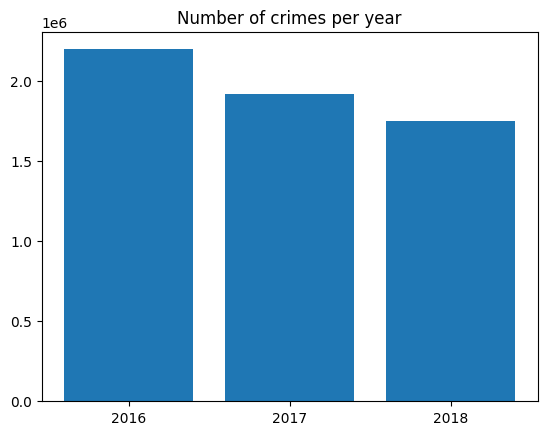

In [28]:
years_int = [int(x) for x in dfs.keys()] #convert years to integers

total_crimes_per_year = {}
for year in years_int:
    df = dfs_Gemeente_All[dfs_Gemeente_All['year'] == year] #filter on year
    total_crimes_per_year[year] = np.sum(df['total_crime']) #get sum of total crimes

x = list(total_crimes_per_year.keys())
height = list(total_crimes_per_year.values())
plt.bar(x=x, height=height, tick_label=list(dfs.keys())) #need to specify tick_labels, otherwise it will show decimals
plt.title("Number of crimes per year")
plt.show()

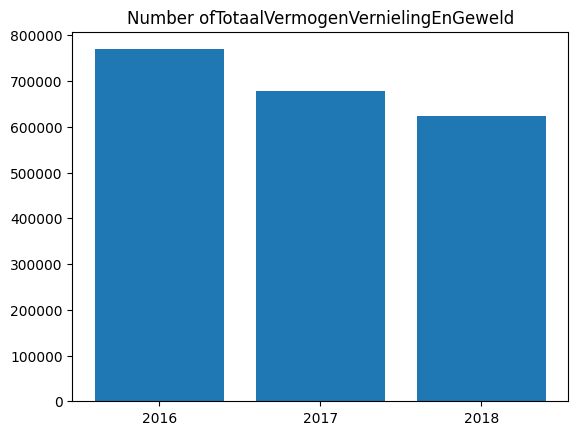

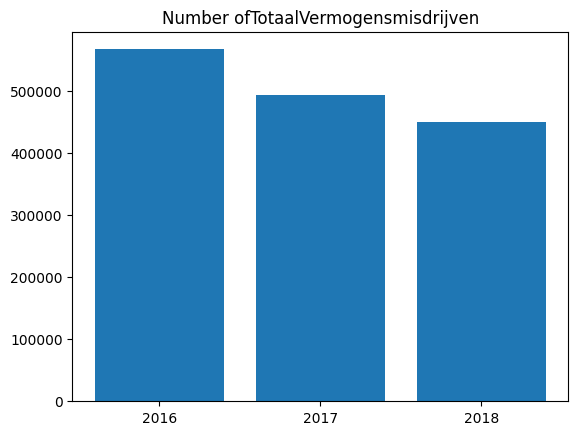

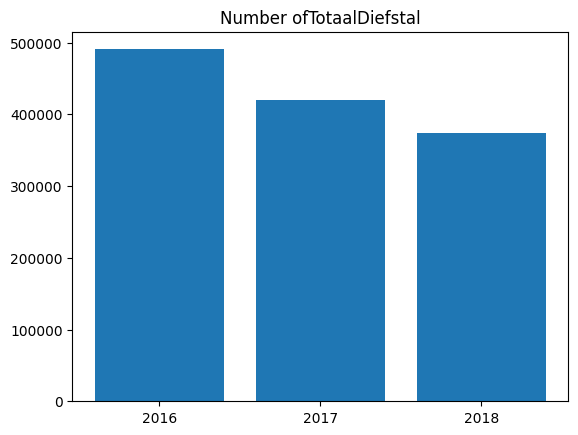

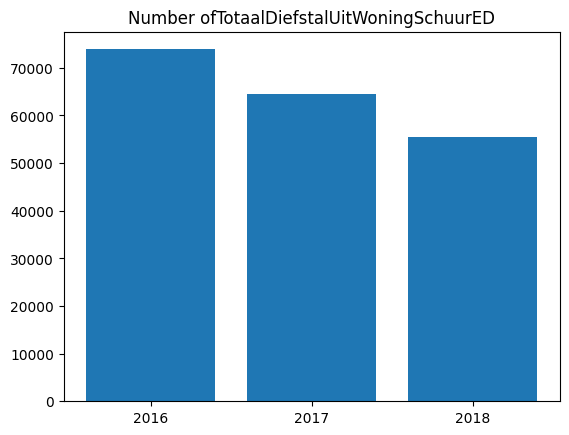

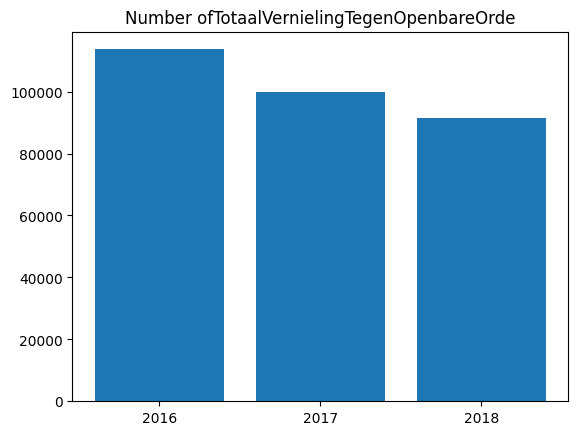

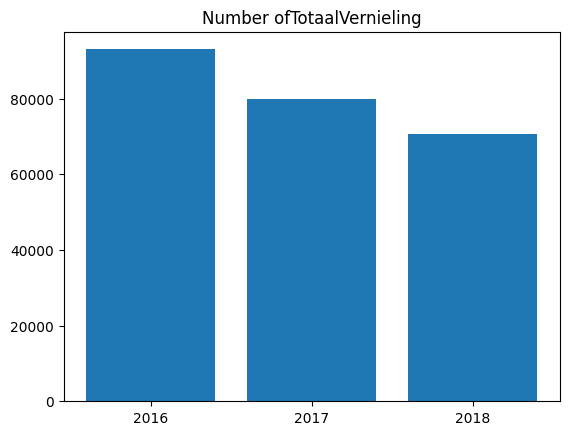

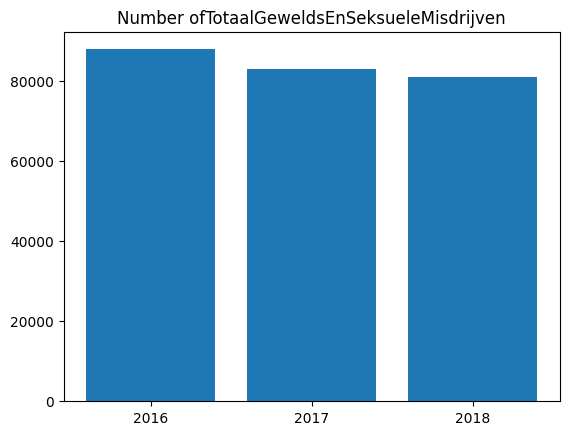

In [29]:
for fixed in to_fix:
    years_int = [int(x) for x in dfs.keys()] #convert years to integers
    height = [sum(dfs_Gemeente_All[dfs_Gemeente_All['year'] == x][fixed]) for x in years_int]
    #height = [sum(dfs[x][fixed]) for x in dfs.keys()]
    years = list(dfs.keys())

    # Sort based on the year to give a good visualization about the time
    height = [x for _, x in sorted(zip(years, height))]
    years.sort()

    plt.bar(x=years, height=height)
    plt.title(str("Number of" + fixed))
    plt.show()

## Let's do some EDA when considering each dataset separately.

We first needed to create a tuple of the name of the province and the actual number.

In [30]:
tuples_total_crime = []
tuples_crime_per_capita = []
dfs_province = dfs_gemeente_and_features.groupby('Province').sum()
dfs_province = dfs_province.reset_index()

for i in range(len(dfs_province)):
    tuples_total_crime.append((dfs_province['Province'][i], dfs_province['total_crime'][i]))
    tuples_crime_per_capita.append((dfs_province['Province'][i], dfs_province['crime_per_capita'][i]))

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_2728\1208038413.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs_province = dfs_gemeente_and_features.groupby('Province').sum()


To reduce overplotting for the x-labels, we used the official abbreviations for the provinces.

In [31]:
short_province = {
    'Friesland': 'F',
    'Drenthe': 'D',
    'Overijssel': 'O',
    'Flevoland': 'Fle',
    'Gelderland': 'Gld',
    'Utrecht': 'U',
    'Noord-Holland': 'NH',
    'Zuid-Holland': 'ZH',
    'Zeeland': 'Z',
    'Noord-Brabant': 'NB',
    'Limburg': 'L',
    'Zeeland': 'Z',
    'Groningen': 'Gr'
}

Plot total crime per province

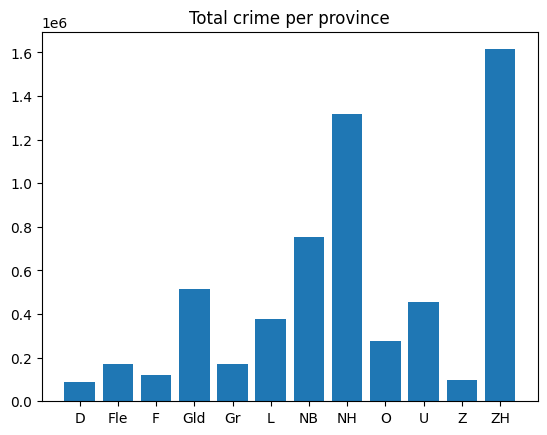

In [32]:
x = [short_province[tuples_total_crime[i][0]] for i in range(len(tuples_total_crime))]
height = [tuples_total_crime[i][1] for i in range(len(tuples_total_crime))]
plt.bar(x=x, height=height)
plt.title("Total crime per province")
plt.show()

Plot crime per capita per province

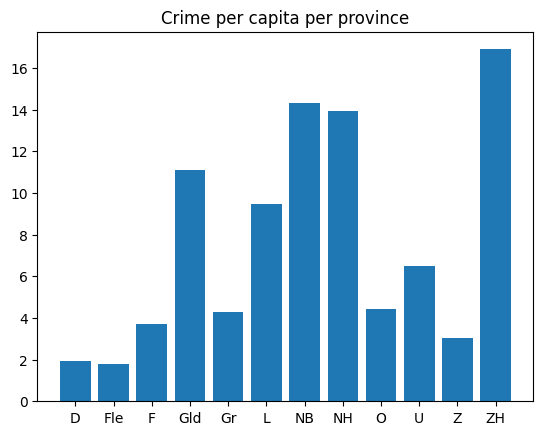

In [33]:
x = [short_province[tuples_crime_per_capita[i][0]] for i in range(len(tuples_crime_per_capita))]
height = [tuples_crime_per_capita[i][1] for i in range(len(tuples_crime_per_capita))]
plt.bar(x=x, height=height)
plt.title("Crime per capita per province")
plt.show()

Above we see the total crime per province and the crime per capita per province. This shows that using the crime per capita data may be more indicative for the provinces.

Let's have a look at the correlation for the entire dataframe.

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_2728\250188780.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(relative_crimes.corr())


                                     AantalInwoners  \
AantalInwoners                             1.000000   
TotaalVermogenVernielingEnGeweld           0.573719   
TotaalVermogensmisdrijven                  0.423468   
TotaalDiefstal                             0.066972   
Fietsendiefstal                           -0.196459   
DiefstalOverigeVervoermiddelen            -0.180818   
DiefstalUitVanafVervoermiddelen           -0.137413   
ZakkenrollerijStraatroofEnBeroving        -0.378224   
TotaalDiefstalUitWoningSchuurED            0.436616   
DiefstalUitNietResidentieleGebouwen        0.019060   
OverigeDiefstalInbraak                     0.215338   
OverigeVermogensmisdrijven                 0.943795   
TotaalVernielingTegenOpenbareOrde          0.547788   
TotaalVernieling                           0.566008   
VernielingAanAuto                          0.384509   
OverigeVernieling                          0.565059   
OverigeVernielingTegenOpenbareOrde         0.270356   

         

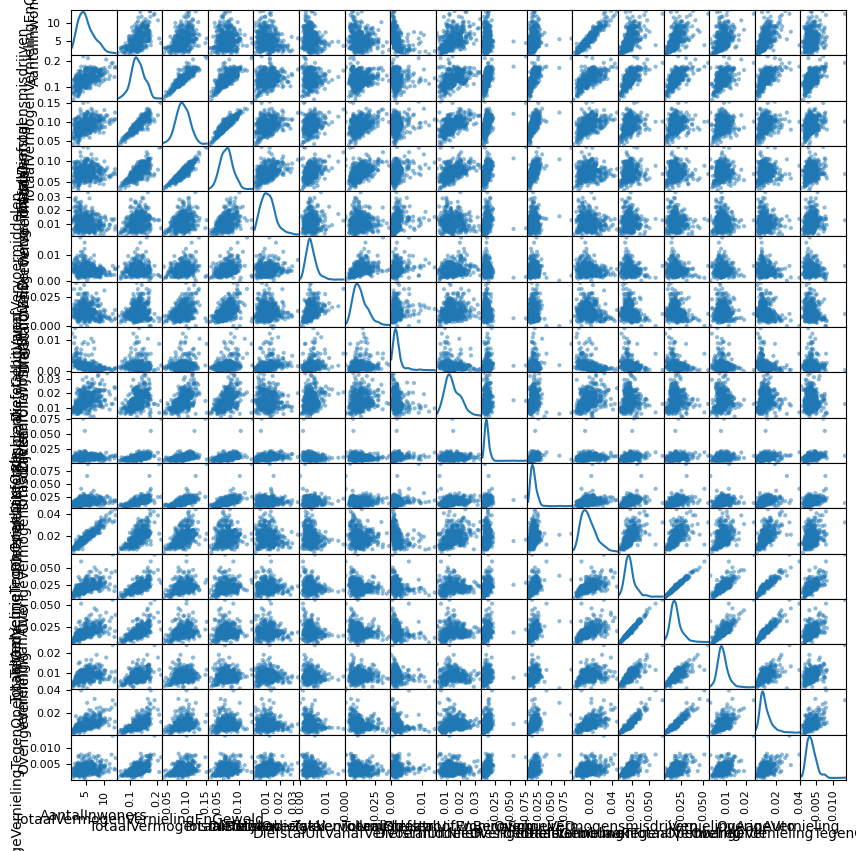

In [34]:
print(relative_crimes.corr())
pd.plotting.scatter_matrix(relative_crimes, figsize=(10, 10), diagonal='kde')
plt.show()

The plotting of this giant plot is not that sensible since some theft/crime numbers are made up of each other. Therefore, we will later investigate the main principle components (dimensionality reduction) and work with those.

The plot below shows the spread and distribution of the data.

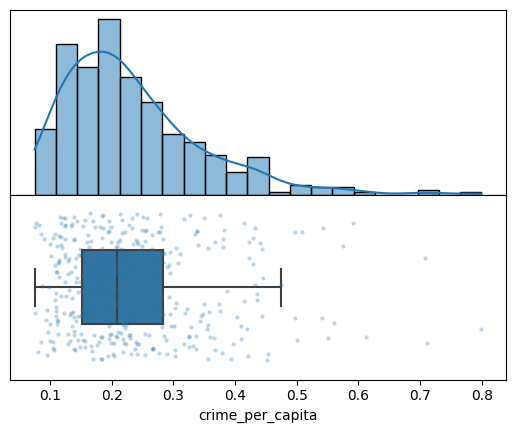

In [35]:
# Plot inspiration from Data Analysis course notebook.

fig, axs = plt.subplots(nrows=2)

sns.histplot(
    dfs_gemeente_and_features['crime_per_capita'],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    dfs_gemeente_and_features['crime_per_capita'], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    dfs_gemeente_and_features['crime_per_capita'],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

spacer = np.max(dfs_gemeente_and_features['crime_per_capita']) * 0.05
xmin = np.min(dfs_gemeente_and_features['crime_per_capita']) - spacer
xmax = np.max(dfs_gemeente_and_features['crime_per_capita']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

plt.subplots_adjust(hspace=0)
axs[1].set_facecolor('white')

Given that we identified the per capita information to be more useful than the total values, the features that were based on totals were divided by the total number of residents in the respective municipality to also make these per capita values.

In [36]:
relative_gemeente_features = dfs_gemeente_and_features.iloc[:,21:]
relative_gemeente_features['index'] = dfs_gemeente_and_features['index']
#relative_gemeente_features=relative_gemeente_features.set_index('index')
relative_gemeente_features['Bevolkingsdichtheid_57'] = relative_gemeente_features['Bevolkingsdichtheid_57'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['TotaalAantalBanen_112'] = relative_gemeente_features['TotaalAantalBanen_112'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Werkloosheid_155'] = relative_gemeente_features['Werkloosheid_155'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Mannen_2'] = relative_gemeente_features['Mannen_2'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Vrouwen_3'] = relative_gemeente_features['Vrouwen_3'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)

relative_gemeente_features.drop(columns=['TotaalMetMigratieachtergrond_35','ParticuliereHuishoudensExclStudenten_121','ID'], inplace=True)

relative_gemeente_features

,Mannen_2,Vrouwen_3,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155,Province,total_crime,crime_per_capita,index
0,0.482850,0.509323,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,29.033333,0.016493,Groningen,2617.100000,0.219476,GM0003
1,0.500653,0.500749,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,30.150000,0.016727,Groningen,1201.533333,0.114844,GM0005
2,0.506875,0.490218,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,29.600000,0.016769,Groningen,1460.200000,0.163242,GM0007
3,0.494004,0.503169,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,30.900000,0.014363,Groningen,802.316667,0.109746,GM0009
4,0.499927,0.495360,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,30.066667,0.016556,Groningen,6799.900000,0.272370,GM0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0.507558,0.491531,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,29.800000,0.014421,Friesland,6267.950000,0.135929,GM1949
387,0.505854,0.504578,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,30.300000,0.013774,Groningen,5145.500000,0.208455,GM1950
388,0.501411,0.498179,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,30.000000,0.015914,Groningen,12565.750000,0.206162,GM1952
389,0.504448,0.503590,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,31.266667,0.014512,Gelderland,6817.600000,0.192740,GM1955


The following plots below were created to get a feeling for which features had a strong correlation (positive or negative) with the crime_per_capita value.

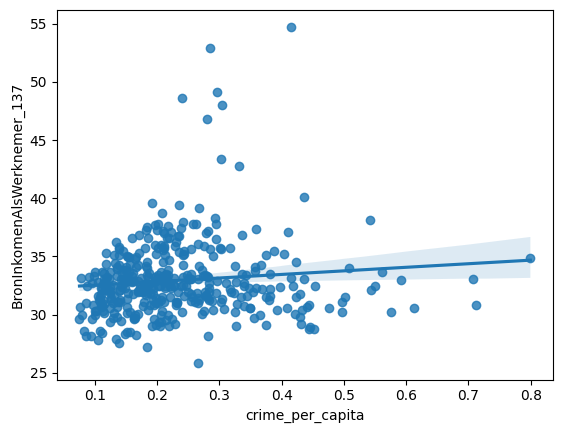

In [37]:
sns.regplot(x=relative_gemeente_features['crime_per_capita'], y=relative_gemeente_features['BronInkomenAlsWerknemer_137'])
plt.show()

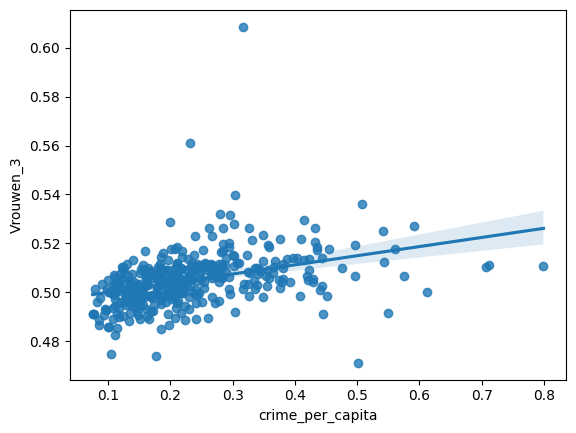

In [38]:

sns.regplot(x=relative_gemeente_features['crime_per_capita'], y=relative_gemeente_features['Vrouwen_3'])
plt.show()

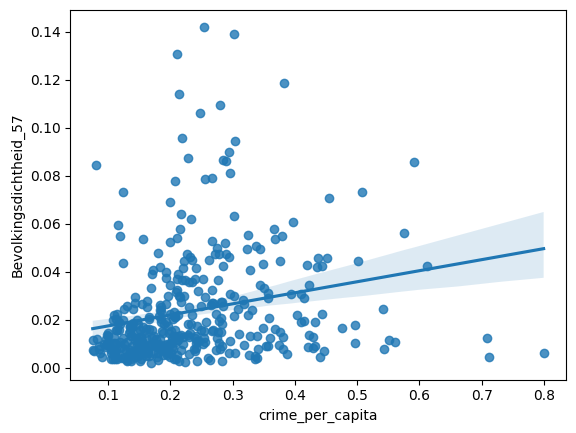

In [39]:
sns.regplot(x=relative_gemeente_features['crime_per_capita'], y=relative_gemeente_features['Bevolkingsdichtheid_57'])
plt.show()

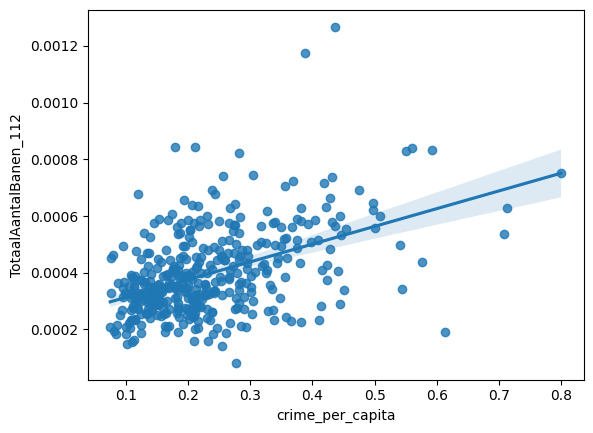

In [40]:
sns.regplot(x=relative_gemeente_features['crime_per_capita'], y=relative_gemeente_features['TotaalAantalBanen_112'])
plt.show()

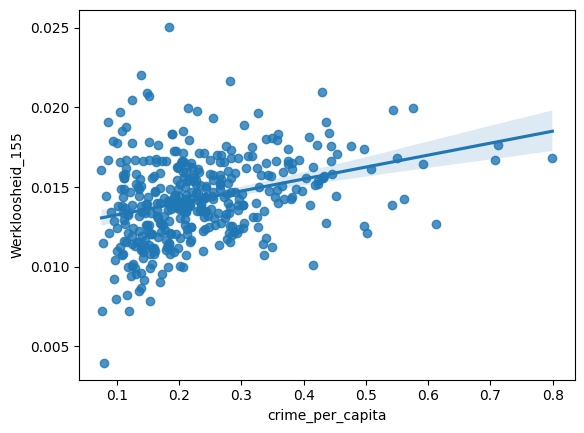

In [41]:

sns.regplot(x=relative_gemeente_features['crime_per_capita'], y=relative_gemeente_features['Werkloosheid_155'])

plt.show()

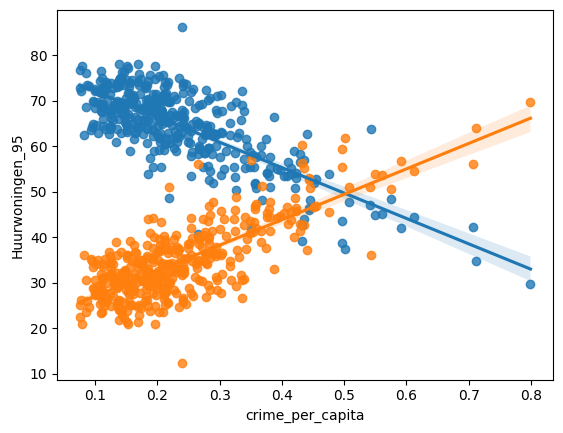

In [42]:
sns.regplot(x=relative_gemeente_features['crime_per_capita'], y=relative_gemeente_features['Koopwoningen_94'])
sns.regplot(x=relative_gemeente_features['crime_per_capita'], y=relative_gemeente_features['Huurwoningen_95'])

plt.show()

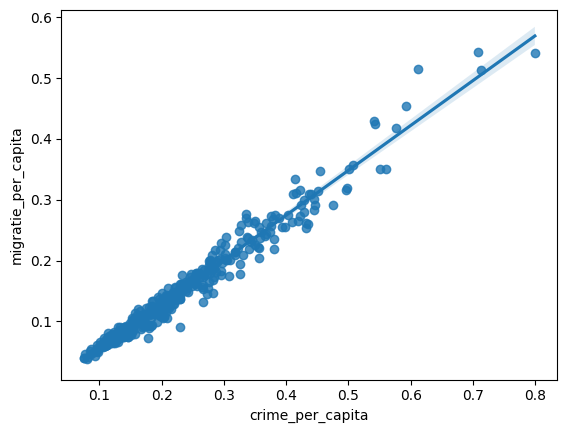

In [43]:
dfs_gemeente_and_features['migratie_per_capita'] = dfs_gemeente_and_features['TotaalMetMigratieachtergrond_35'].div(dfs_gemeente_and_features['AantalInwoners'])
sns.regplot(x=dfs_gemeente_and_features['crime_per_capita'], y=dfs_gemeente_and_features['migratie_per_capita'])

plt.show()

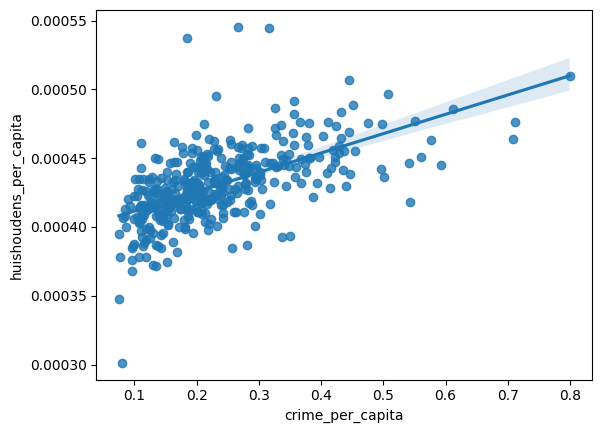

In [44]:
dfs_gemeente_and_features['huishoudens_per_capita'] = dfs_gemeente_and_features['ParticuliereHuishoudensExclStudenten_121'].div(dfs_gemeente_and_features['AantalInwoners'])

sns.regplot(x=dfs_gemeente_and_features['crime_per_capita'], y=dfs_gemeente_and_features['huishoudens_per_capita'])

plt.show()

From these plots we can see which features show linearity with the crimes per capita we are trying to predict. Features that show no interesting trends can be dropped. Some of these would show even stronger trends when we would remove the bigger cities.

In [45]:
relative_gemeente_features.drop(columns=['Mannen_2','Vrouwen_3','BronInkomenAlsWerknemer_137'], inplace=True)
relative_gemeente_features

,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,Werkloosheid_155,Province,total_crime,crime_per_capita,index
0,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,0.016493,Groningen,2617.100000,0.219476,GM0003
1,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,0.016727,Groningen,1201.533333,0.114844,GM0005
2,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,0.016769,Groningen,1460.200000,0.163242,GM0007
3,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,0.014363,Groningen,802.316667,0.109746,GM0009
4,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,0.016556,Groningen,6799.900000,0.272370,GM0010
...,...,...,...,...,...,...,...,...,...,...,...
386,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,0.014421,Friesland,6267.950000,0.135929,GM1949
387,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,0.013774,Groningen,5145.500000,0.208455,GM1950
388,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,0.015914,Groningen,12565.750000,0.206162,GM1952
389,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,0.014512,Gelderland,6817.600000,0.192740,GM1955


## One Hot Encoding

The province that the municipality is located in was one-hot encoded to be a feature in the model

In [46]:
cats = list(short_province.keys()) #we can use the mapper we used earlier

cat_type = CategoricalDtype(categories=cats)
relative_gemeente_features['Province'] = relative_gemeente_features['Province'].astype(cat_type)
relative_gemeente_features = pd.get_dummies(relative_gemeente_features,
                          prefix='pro',
                          columns=['Province'], 
                          drop_first=True)

relative_gemeente_features

,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,Werkloosheid_155,total_crime,crime_per_capita,index,...,pro_Overijssel,pro_Flevoland,pro_Gelderland,pro_Utrecht,pro_Noord-Holland,pro_Zuid-Holland,pro_Zeeland,pro_Noord-Brabant,pro_Limburg,pro_Groningen
0,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,0.016493,2617.100000,0.219476,GM0003,...,0,0,0,0,0,0,0,0,0,1
1,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,0.016727,1201.533333,0.114844,GM0005,...,0,0,0,0,0,0,0,0,0,1
2,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,0.016769,1460.200000,0.163242,GM0007,...,0,0,0,0,0,0,0,0,0,1
3,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,0.014363,802.316667,0.109746,GM0009,...,0,0,0,0,0,0,0,0,0,1
4,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,0.016556,6799.900000,0.272370,GM0010,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,0.014421,6267.950000,0.135929,GM1949,...,0,0,0,0,0,0,0,0,0,0
387,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,0.013774,5145.500000,0.208455,GM1950,...,0,0,0,0,0,0,0,0,0,1
388,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,0.015914,12565.750000,0.206162,GM1952,...,0,0,0,0,0,0,0,0,0,1
389,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,0.014512,6817.600000,0.192740,GM1955,...,0,0,1,0,0,0,0,0,0,0


## Dimensionality Reduction using PCA/SVD

Since there are so many features, let's have a look if we can reduce the dimensionality by PCA and SVD.

In [47]:
def dataframe_PCA(data: pd.DataFrame, columns_to_drop: list, limit_components: int = -1) -> pd.DataFrame:
    """
    Generates PCA dataframe by the data. It also offers some cleaning and it has automatic scaling.

    Args:
        data (pd.DataFrame): data that needs to be cleaned (with column removal) and scaled
        columns_to_drop (list): columns to drop for cleaning
        limit_components (int, optional): limits the amount of components for PCA. Defaults to -1 which is no limit.

    Returns:
        pd.DataFrame: PCA dataframe
    """
    cleaned_data = data.drop(columns=columns_to_drop) # Some cleaning before PCA
    print(cleaned_data.columns)
    X = scale(cleaned_data.values) # Scale dataset

    # Create PCA and transform to new coordinate system
    if (limit_components == -1):
        PCA_model = PCA()
    else:
        PCA_model = PCA(limit_components)
    X_PCA = PCA_model.fit_transform(X)

    # Create new DataFrame
    columns = ["PC_" + str(i) for i in range(len(cleaned_data.columns))]
    df_PCA = pd.DataFrame(X_PCA, columns=columns)

    print(PCA_model.singular_values_)
    print(PCA_model.get_feature_names_out())

    return df_PCA

df_PCA = dataframe_PCA(data=relative_gemeente_features, columns_to_drop=['index'])

Index(['Bevolkingsdichtheid_57', 'Koopwoningen_94', 'Huurwoningen_95',
       'EigendomOnbekend_96', 'TotaalAantalBanen_112',
       'TypePaarZonderKind_135', 'Werkloosheid_155', 'total_crime',
       'crime_per_capita', 'pro_Drenthe', 'pro_Overijssel', 'pro_Flevoland',
       'pro_Gelderland', 'pro_Utrecht', 'pro_Noord-Holland',
       'pro_Zuid-Holland', 'pro_Zeeland', 'pro_Noord-Brabant', 'pro_Limburg',
       'pro_Groningen'],
      dtype='object')
[37.7744308  28.40532576 23.41601967 22.76225048 21.85378089 21.15820418
 20.94351349 20.67552084 20.6298908  20.28263937 20.12000141 18.29837719
 17.39969067 15.2559906  14.54716471 13.1431348  12.398063    7.90802129
  3.96278573  0.05220455]
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9'
 'pca10' 'pca11' 'pca12' 'pca13' 'pca14' 'pca15' 'pca16' 'pca17' 'pca18'
 'pca19']


In [48]:
df_PCA

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19
0,1.668524,-2.142707,-2.633608,-0.232560,0.171154,-1.762820,-1.142919,0.548573,0.493040,-1.890875,0.028084,-0.780569,-0.666633,0.284222,-0.047373,1.312817,1.169216,0.601280,-0.052744,-0.002897
1,-1.200189,-1.985281,-1.967717,-0.486152,0.556580,-1.579901,-1.237746,0.582806,0.579919,-1.675930,0.205172,-0.293317,0.313398,0.808354,0.755746,0.769864,-0.149402,0.191600,-0.059629,-0.004609
2,-1.586883,-2.451168,-2.004018,-0.086869,0.889634,-1.316429,-1.268282,0.830395,0.587211,-1.668078,0.228942,0.242380,0.676053,0.283441,0.354688,0.454695,-0.190351,-0.551725,0.036263,-0.000171
3,-2.638124,-1.290340,-2.101802,-0.692863,0.566293,-1.458483,-1.257110,0.510343,0.524901,-1.742274,0.427010,-0.594660,1.037230,0.433785,0.774683,1.069752,-0.128585,-0.314384,0.208563,-0.000838
4,0.433463,-2.469542,-1.489109,-0.294861,0.447713,-1.379913,-1.210690,0.625793,0.562643,-1.733592,0.205737,-0.331905,0.346415,1.228771,0.498359,0.659516,0.416718,-0.557417,0.210196,-0.000231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,-1.098364,-0.897173,-0.244608,-0.198599,-0.274050,-0.085181,-0.114899,-0.173885,-0.085856,-0.064894,0.158386,-0.686409,0.337727,-0.151210,-0.732795,-0.691084,-0.071713,0.452604,0.783920,0.003600
387,-1.124482,-2.391430,-1.132572,1.938548,1.557990,-0.651703,-1.354543,1.656986,0.661725,-1.533641,-0.221050,2.856739,0.543077,0.720213,-0.570725,0.966964,-0.092825,-0.910734,0.077424,0.009397
388,-0.121754,-2.408667,-1.613200,-0.111221,0.523969,-1.431280,-1.301832,0.716218,0.558539,-1.753134,0.218439,-0.202108,0.686147,0.765449,0.279914,0.638314,0.629683,-0.165827,0.071506,-0.000235
389,-0.305989,-0.751635,0.430603,0.909482,-1.032840,-1.357319,1.639866,-0.496560,-0.103485,-0.031779,0.389847,-1.261507,0.143549,0.312309,0.112410,-0.267248,-0.229837,-0.131571,-0.048674,-0.000499


Since we did not see enough variance explaining the first few principle components, we left this out of the final pipeline. However, we kept it in the notebook to show that we made a serious attempt to reduce the dimensions of our data.

## Regression time

### Let's use regular cross-validation 

To test Linear Regression against Lasso and Ridge (regularized models with L1 and L2 respectively)

But first, let's have a look at the distribution of the number we want to predict.
We found that we might need to relax the problem.

In [49]:
sorted = relative_gemeente_features.sort_values(by=['crime_per_capita'], ascending=False)
sorted = sorted[['crime_per_capita','index']]
sorted[sorted['crime_per_capita']>0.5]
relative_crimes_without_cities = relative_gemeente_features[relative_gemeente_features['crime_per_capita']<0.5]
relative_crimes_without_cities

,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,Werkloosheid_155,total_crime,crime_per_capita,index,...,pro_Overijssel,pro_Flevoland,pro_Gelderland,pro_Utrecht,pro_Noord-Holland,pro_Zuid-Holland,pro_Zeeland,pro_Noord-Brabant,pro_Limburg,pro_Groningen
0,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,0.016493,2617.100000,0.219476,GM0003,...,0,0,0,0,0,0,0,0,0,1
1,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,0.016727,1201.533333,0.114844,GM0005,...,0,0,0,0,0,0,0,0,0,1
2,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,0.016769,1460.200000,0.163242,GM0007,...,0,0,0,0,0,0,0,0,0,1
3,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,0.014363,802.316667,0.109746,GM0009,...,0,0,0,0,0,0,0,0,0,1
4,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,0.016556,6799.900000,0.272370,GM0010,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,0.014421,6267.950000,0.135929,GM1949,...,0,0,0,0,0,0,0,0,0,0
387,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,0.013774,5145.500000,0.208455,GM1950,...,0,0,0,0,0,0,0,0,0,1
388,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,0.015914,12565.750000,0.206162,GM1952,...,0,0,0,0,0,0,0,0,0,1
389,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,0.014512,6817.600000,0.192740,GM1955,...,0,0,1,0,0,0,0,0,0,0


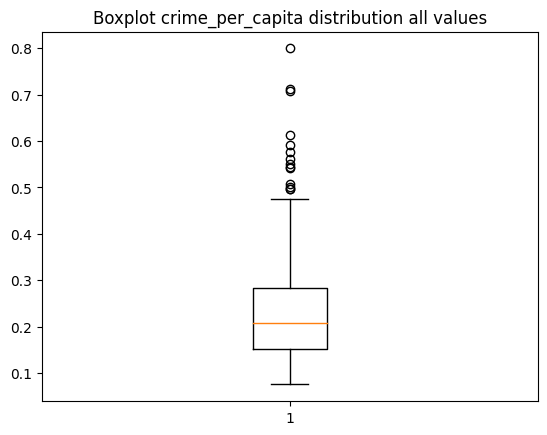

In [50]:
plt.boxplot(relative_gemeente_features['crime_per_capita'])
plt.title('Boxplot crime_per_capita distribution all values')
plt.show()

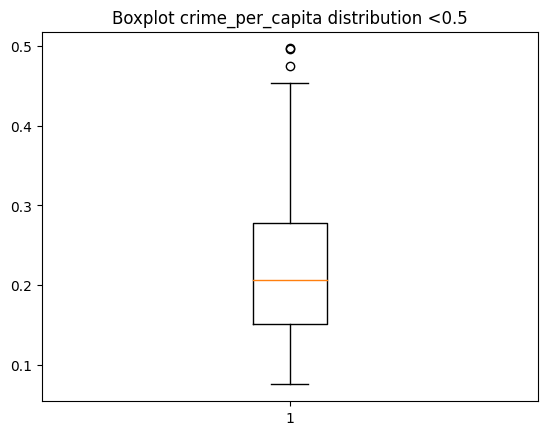

In [51]:
plt.boxplot(relative_crimes_without_cities['crime_per_capita'])
plt.title('Boxplot crime_per_capita distribution <0.5')
plt.show()

In [52]:
relative_gemeente_features = relative_gemeente_features.drop(columns=['total_crime'])
relative_crimes_without_cities = relative_crimes_without_cities.drop(columns=['total_crime'])

#Make it bigger to reduce Lasso coefficients going to 0.
relative_crimes_without_cities['crime_per_capita'] = relative_crimes_without_cities['crime_per_capita']*100 

In [53]:
def train_pipeline(model_name: str, data: pd.DataFrame, col_name_to_predict: str, column_to_drop: str, folds: int = 5, seed: int = 21, plot_residuals: bool = False):
    """
    Training and validation pipeline for our models

    Args:
        model_name (str): name of the linear model to use
        data (pd.DataFrame): dataframe containing data (features and real value that needs to be regressed)
        col_name_to_predict (str): the column name of the value that needs to be regressed
        column_to_drop (str): additional columns to drop, e.g. 'index'
        folds (int, optional): the number of folds to perform. Defaults to 5.
        seed (int, optional): the random state or seed. Defaults to 21.
        plot_residuals (bool, optional): enables/disables plotting of residuals. Defaults to False.
    """

    # Generate folds and make the X-Y split of the data
    k_folds = KFold(n_splits=folds, shuffle=True, random_state=seed)

    X = data.drop(columns=[col_name_to_predict])
    X = X.drop(columns=[column_to_drop])
    Y = data[col_name_to_predict]

    # Error metrics are MSE and MAE
    errors = {'mse':{'train': [], 'test': []}, 'mae':{'train': [], 'test': []}, 'mape':{'train': [], 'test': []}}
    models = []

    print(model_name)

    # i is folder number
    # x_index is a list with x indices (so train or test indices)

    for i, (train_index, test_index) in enumerate(k_folds.split(X)):
        if(model_name == 'Ridge'):
            model=Ridge(alpha=0.5)
        elif(model_name == 'Lasso'):
            model=Lasso(alpha=0.5)
        else:
            model=LinearRegression()

        #print('Busy with fold', i)

        # Get train data
        X_train = X.iloc[train_index]
        y_train = Y.iloc[train_index]

        # Get test data
        X_test = X.iloc[test_index]
        y_test = Y.iloc[test_index]

        # Fit the model
        model.fit(X=X_train, y=y_train)

        # We used these print statements to analyze our model
        print('Coef', model.coef_)
        print('Bias', model.intercept_)

        y_pred_train = model.predict(X=X_train)
        mse_train = MSE(y_true=y_train, y_pred=y_pred_train)
        mae_train = MAE(y_true=y_train, y_pred=y_pred_train)
        mape_train = MAPE(y_true=y_train, y_pred=y_pred_train)
        errors['mse']['train'].append(mse_train)
        errors['mae']['train'].append(mae_train)
        errors['mape']['train'].append(mape_train)

        y_pred_test = model.predict(X=X_test)
        mse_test = MSE(y_true=y_test, y_pred=y_pred_test)
        mae_test = MAE(y_true=y_test, y_pred=y_pred_test)
        mape_test = MAPE(y_true=y_test, y_pred=y_pred_test)
        errors['mse']['test'].append(mse_test)
        errors['mae']['test'].append(mae_test)
        errors['mape']['test'].append(mape_test)

        models.append(model) #'save' model

        # Residuals plotting
        if plot_residuals:
            residuals = y_test - y_pred_test
            plt.plot(y_test, residuals, '*')
            plt.xlabel("Crime per capita")
            plt.ylabel("Residual")
            plt.show()
        #print('Average value in Y_test:', np.average(y_test))
        #print('STD value in Y_test:', np.std(y_test))

    #print(errors)
    print('Average MSE train error:', np.average(errors['mse']['train']))
    print('Average MSE test error:', np.average(errors['mse']['test']))
    print('Average MAE train error:', np.average(errors['mae']['train']))
    print('Average MAE test error:', np.average(errors['mae']['test']))
    print('Average MAPE train error:', np.average(errors['mape']['train']))
    print('Average MAPE test error:', np.average(errors['mape']['test']))
    print()
    print('Average value in Y:', np.average(Y))
    print('STD value in Y:', np.std(Y))
    print()
    print()

In [54]:
#Some stable parameters
FOLDS = 5
SEED = 21
PLOT_RES = True
PREDICT_COL = 'crime_per_capita'
DROP_COL = 'index'

Let's soften the constraints and only keep the values for crime per capita from 0 to 0.5 --> ```relative_crimes_without_cities```

LR
Coef [ 3.75579438e+00 -6.17092324e+00 -5.43952443e+00 -5.73150661e+00
  1.10854640e+04  3.54968238e-01  1.05177584e+03  4.82726068e+00
  7.17375932e+00  1.68369422e+01  8.07319234e+00  1.11203599e+01
  1.38926195e+01  1.18357984e+01  1.84836085e+01  1.02431100e+01
  1.61954718e+01  4.92571859e+00]
Bias 572.442072799838


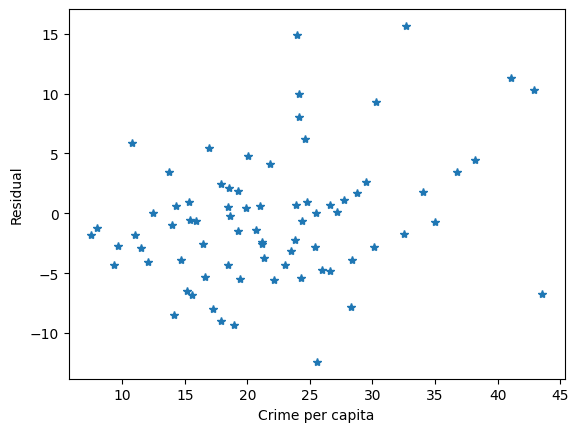

Coef [-6.33213205e-01 -6.42699324e+00 -5.72695372e+00 -5.70705354e+00
  7.11298247e+03  3.80341947e-01  1.00783021e+03  3.99819252e+00
  6.94889259e+00  1.64051820e+01  8.43368393e+00  1.11432839e+01
  1.37005100e+01  1.19312509e+01  1.58960413e+01  1.11202729e+01
  1.59507550e+01  4.02635333e+00]
Bias 600.1926763394345


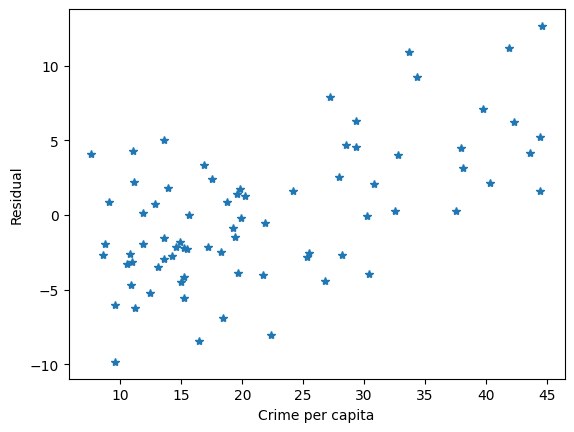

Coef [ 1.72695805e+01 -1.07357996e+00 -3.91828025e-01 -2.81317700e-01
  9.31428327e+03  3.91548776e-01  1.12052392e+03  3.00038078e+00
  5.55759710e+00  1.06713268e+01  7.18862315e+00  1.05250227e+01
  1.18734016e+01  1.09967802e+01  1.22141438e+01  9.56827957e+00
  1.45796741e+01  3.48854744e+00]
Bias 63.35107261325015


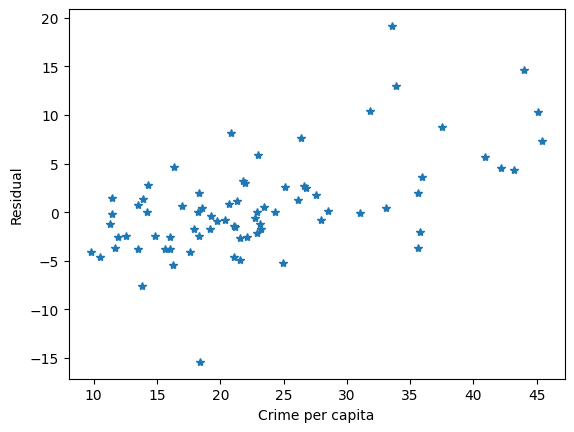

Coef [ 1.60553836e+01 -3.98142386e+00 -3.23672989e+00 -3.22878087e+00
  9.07044357e+03  3.83189732e-01  8.69481160e+02  3.53057469e+00
  6.28187365e+00  1.40605439e+01  7.50531348e+00  1.04749611e+01
  1.23052563e+01  1.13468654e+01  1.47193600e+01  1.03832785e+01
  1.62445601e+01  4.15690575e+00]
Bias 355.6156434773213


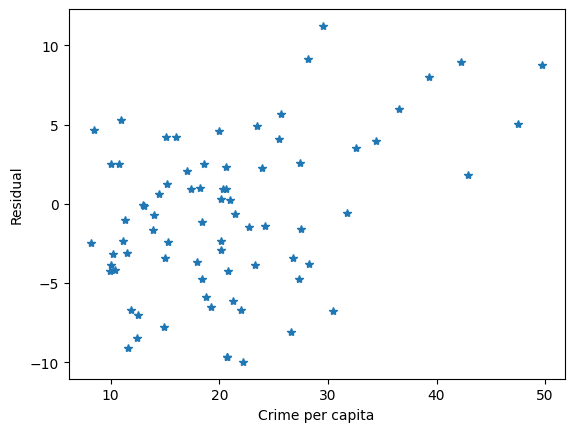

Coef [1.12264111e+01 3.33088783e+00 4.04804161e+00 3.42076010e+00
 7.40210664e+03 4.13731890e-01 1.04739589e+03 4.11091232e+00
 6.97644663e+00 1.45560341e+01 8.14759490e+00 1.07581363e+01
 1.26087633e+01 1.18219030e+01 1.53487608e+01 1.13733856e+01
 1.53681199e+01 4.18486522e+00]
Bias -377.5286276762307


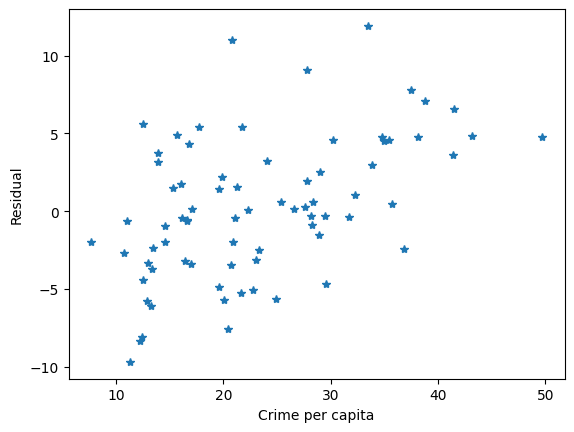

Average MSE train error: 20.35865163845373
Average MSE test error: 24.2306220145313
Average MAE train error: 3.52699964802448
Average MAE test error: 3.7904883741381212
Average MAPE train error: 0.17866448391656137
Average MAPE test error: 0.19119494597971146

Average value in Y: 22.22275266334029
STD value in Y: 9.26695742014054


Ridge
Coef [-0.52214917 -1.01009456 -0.03462159 -0.76922978  0.10674626  0.35571266
  2.24442296  2.88813062  2.64934988 12.36494082  3.19809746  5.88011719
  7.86522795  4.98300106 11.76478276  6.76304741 12.23868147  1.52074751]
Bias 71.9891938605178


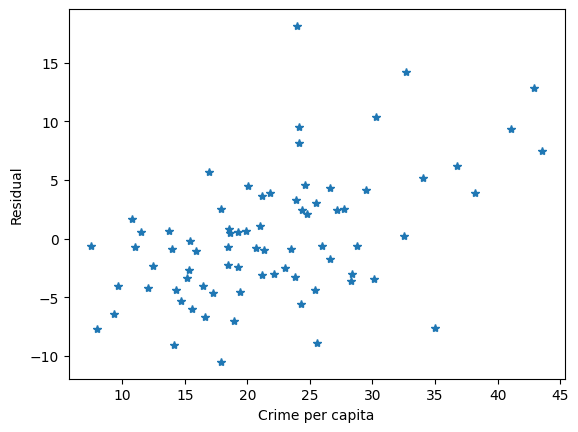

Coef [-1.31819484 -1.2284924  -0.32766248 -1.01139239  0.09023326  0.39504137
  2.33474374  1.78497586  2.18078532  9.91262418  2.55183119  4.74587997
  7.44686723  4.62278315  8.96615952  6.72531974 11.59124702  0.56159184]
Bias 95.76335278736761


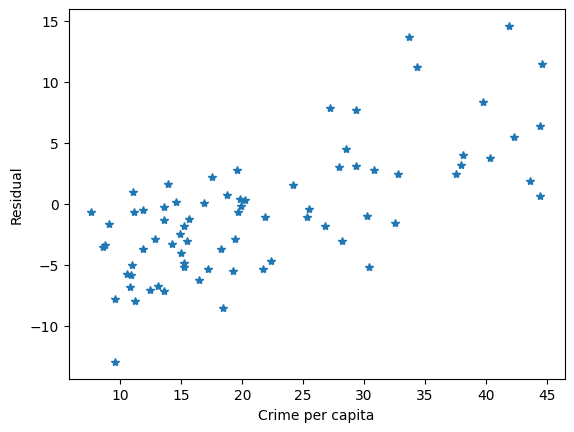

Coef [ 2.47856287 -0.69738787  0.2300242  -0.91213545  0.10435893  0.43957253
  2.23619014  2.43094171  1.65820413  6.00743052  2.33986183  5.72866197
  7.27716205  5.03573382  6.24699815  6.65117461 11.92935466  0.94122109]
Bias 40.09322699131488


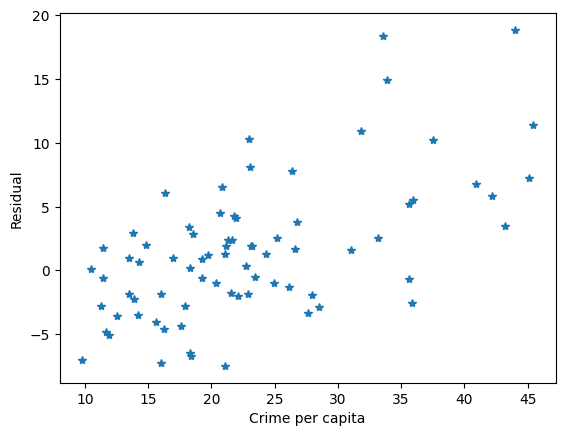

Coef [ 2.80107584 -0.65261935  0.30822642 -0.20003935  0.08923061  0.42907467
  1.87252769  1.47225089  2.13071345  9.40359251  2.52199319  5.42139326
  7.31046065  5.28611641  8.78479609  7.01901005 11.99783351  1.68030412]
Bias 34.51445783880838


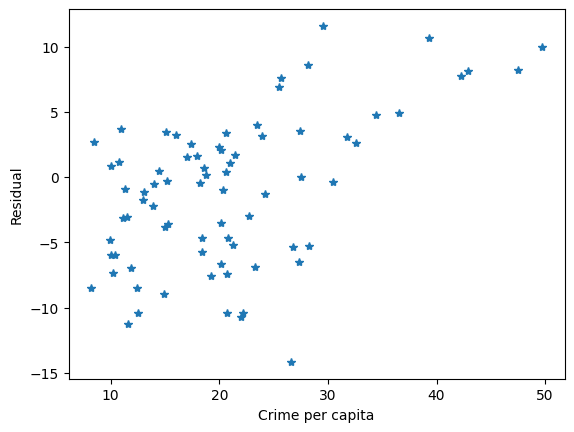

Coef [ 1.51741387  1.24487487  2.19891919  0.96520721  0.08169282  0.47828029
  2.27529298  2.34590819  2.25387688  9.60560589  2.8699856   4.84445679
  6.78349918  5.07508716  8.94508886  7.75119649 12.22565311  1.78532031]
Bias -156.41202766845024


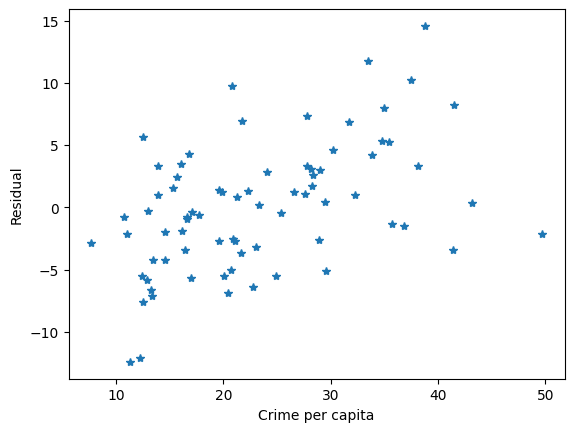

Average MSE train error: 25.98964545155501
Average MSE test error: 29.638292030864555
Average MAE train error: 3.9588026322616736
Average MAE test error: 4.208802034637165
Average MAPE train error: 0.2013087704850694
Average MAPE test error: 0.21364206727990834

Average value in Y: 22.22275266334029
STD value in Y: 9.26695742014054


Lasso
Coef [ 0.         -0.          0.94529136 -0.          0.          0.46094568
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          1.93122455 -0.        ]
Bias -26.032136440461972


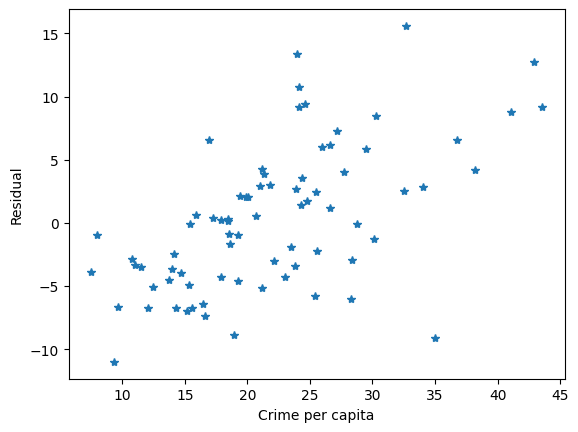

Coef [ 0.         -0.          0.85283406 -0.          0.          0.4752836
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.          1.38409335 -0.        ]
Bias -23.094532555030362


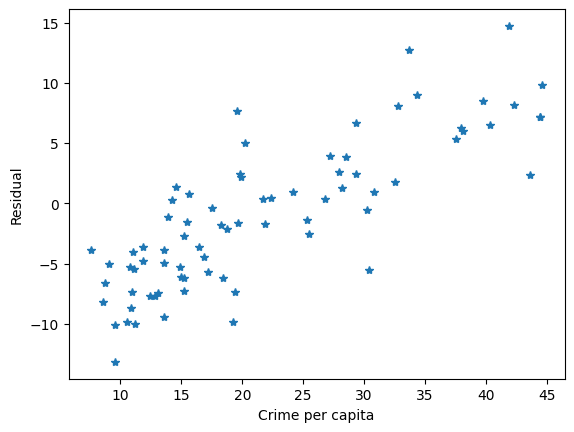

Coef [ 0.         -0.          0.90375707 -0.          0.          0.5541012
  0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.          0.          1.95020871 -0.        ]
Bias -28.06838179128336


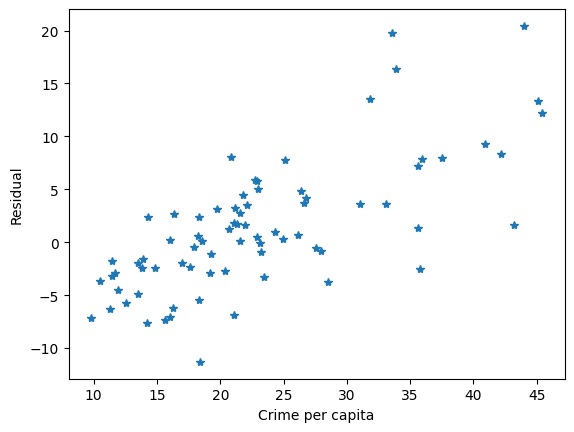

Coef [ 0.         -0.          0.93156537 -0.          0.          0.5253943
  0.         -0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.40968264 -0.        ]
Bias -27.421898101881126


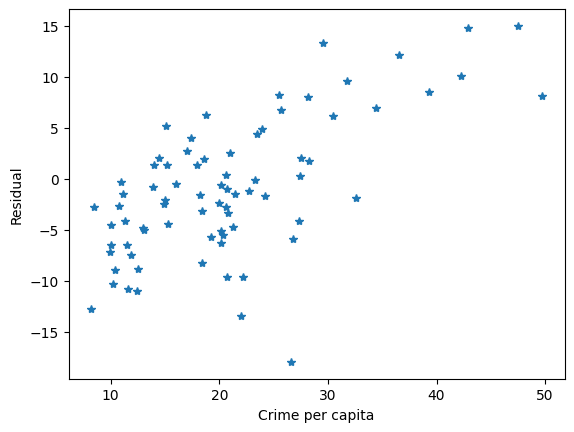

Coef [ 0.         -0.          0.91871748 -0.          0.          0.55551255
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.          1.13555501 -0.        ]
Bias -28.391790632183273


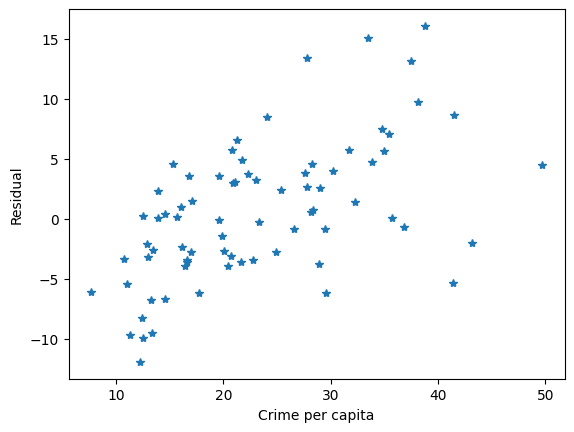

Average MSE train error: 36.28319910337258
Average MSE test error: 37.765396964035745
Average MAE train error: 4.7655267010253795
Average MAE test error: 4.856695980334161
Average MAPE train error: 0.2498896377992585
Average MAPE test error: 0.25382178840990177

Average value in Y: 22.22275266334029
STD value in Y: 9.26695742014054




In [63]:
train_pipeline(
    model_name='LR',
    data=relative_crimes_without_cities,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

train_pipeline(
    model_name='Ridge',
    data=relative_crimes_without_cities,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

train_pipeline(
    model_name='Lasso',
    data=relative_crimes_without_cities,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

Now, let's try with the big cities included --> ```relative_gemeente_features```

LR
Coef [ 1.24489474e-01 -1.42128440e-01 -1.33610711e-01 -1.28779804e-01
  7.98354165e+01  3.27153359e-03  8.93919486e+00  3.65524826e-02
  6.64692282e-02  1.88741217e-01  8.23395367e-02  1.21168720e-01
  1.33238072e-01  1.33292386e-01  1.55062357e-01  1.21581317e-01
  1.72679483e-01  4.86130948e-02]
Bias 13.758178432570318


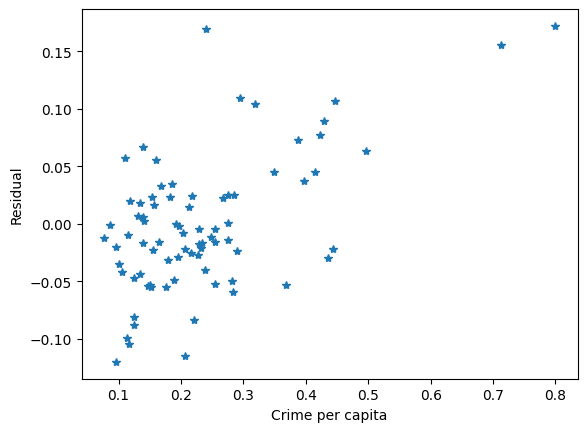

Coef [-1.17121260e-01 -5.09269927e-02 -4.25003652e-02 -4.11532699e-02
  8.18906359e+01  4.39873888e-03  1.13033847e+01  4.86637727e-02
  7.82503107e-02  1.70951498e-01  8.83104060e-02  1.24133841e-01
  1.49275903e-01  1.43707674e-01  1.65133522e-01  1.18261926e-01
  1.69811930e-01  4.31172445e-02]
Bias 4.571759660878618


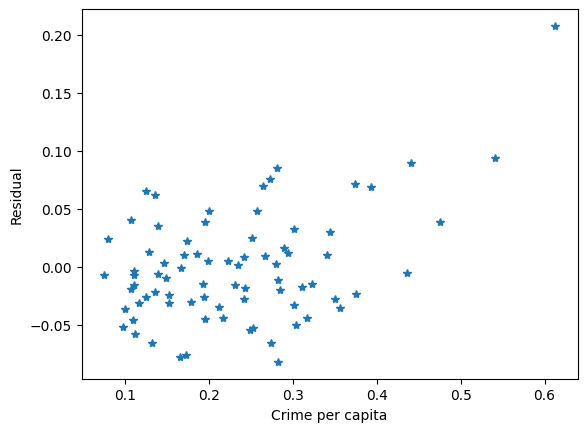

Coef [-4.81521574e-02 -1.08290021e-01 -9.96208878e-02 -1.00229590e-01
  8.16186554e+01  4.22768959e-03  1.01652410e+01  4.54181534e-02
  6.80501477e-02  2.16214085e-01  8.34938563e-02  1.20085210e-01
  1.39537377e-01  1.19345132e-01  1.55523427e-01  1.14056794e-01
  1.62082185e-01  4.18303450e-02]
Bias 10.329180909360389


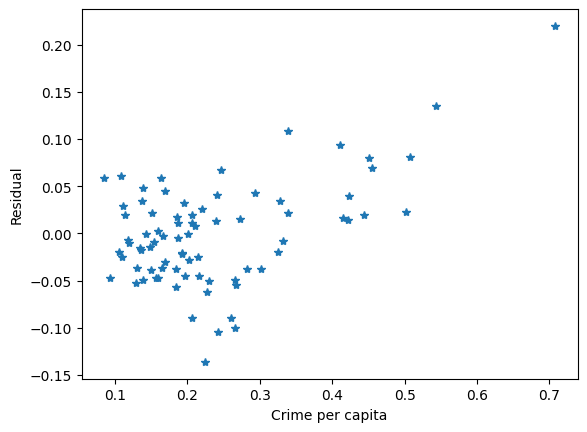

Coef [-1.50059356e-01 -1.48532370e-01 -1.39559356e-01 -1.38476833e-01
  7.96992995e+01  3.83348605e-03  1.15072476e+01  4.62042594e-02
  7.71658480e-02  1.86639299e-01  8.10105820e-02  1.24760713e-01
  1.46771135e-01  1.35081732e-01  1.61715015e-01  1.16370918e-01
  1.72241344e-01  4.11816247e-02]
Bias 14.335137815314546


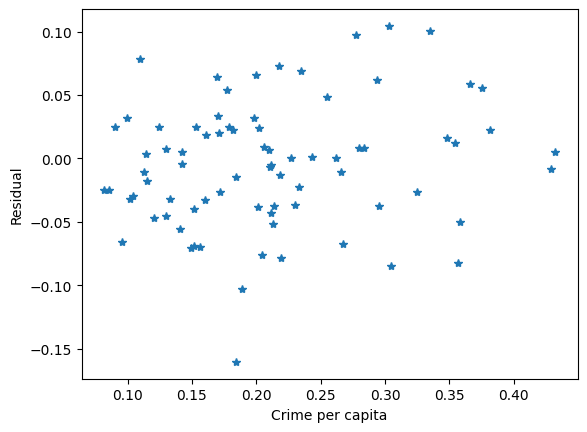

Coef [-1.08235541e-01 -1.49529793e-02 -6.01434494e-03 -1.02796400e-02
  5.48989090e+01  5.25081809e-03  1.06016038e+01  4.37578831e-02
  6.65670559e-02  1.83087381e-01  7.72230742e-02  9.74575306e-02
  1.38452850e-01  1.29093321e-01  1.62574524e-01  1.04963844e-01
  1.70078792e-01  4.08807554e-02]
Bias 0.9600052670579534


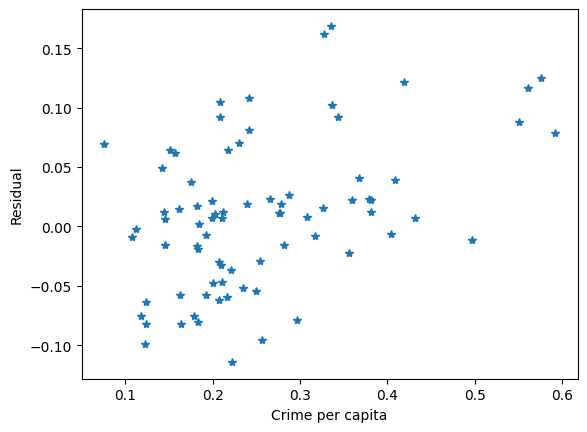

Average MSE train error: 0.0026358047548458137
Average MSE test error: 0.00305332244026367
Average MAE train error: 0.039186303700372085
Average MAE test error: 0.042134066520763055
Average MAPE train error: 0.19032135731429534
Average MAPE test error: 0.2040720123733577

Average value in Y: 0.2338318098958433
STD value in Y: 0.1132114802988695


Ridge
Coef [ 0.01738951 -0.0340874  -0.02356148 -0.02631214  0.00069115  0.00342112
  0.02114593  0.02037719  0.0240511   0.1434849   0.03260814  0.07049419
  0.07802971  0.07030062  0.0958621   0.0879605   0.13246914  0.01420694]
Bias 3.0886834376773944


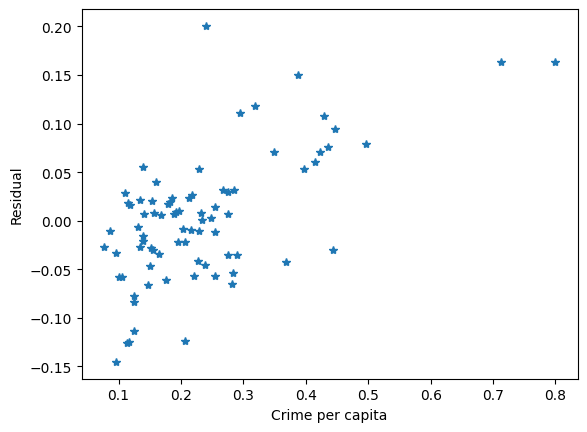

Coef [-0.01709655 -0.0112266  -0.00042486 -0.00586743  0.00106387  0.00470098
  0.02574835  0.02765797  0.02532758  0.13298864  0.0289709   0.05734895
  0.08313346  0.06423397  0.09462817  0.0749322   0.12470204  0.01264099]
Bias 0.7562925758246486


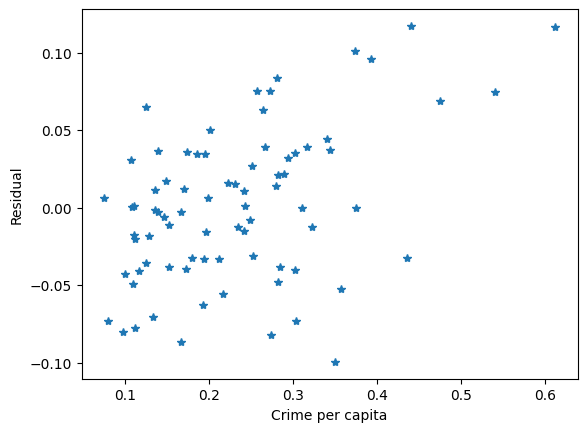

Coef [-0.01923715 -0.01896019 -0.00808697 -0.01446713  0.00104952  0.00480604
  0.02262711  0.02353336  0.02137711  0.12077422  0.02804738  0.06256932
  0.0770305   0.04882284  0.08834875  0.07570227  0.11918592  0.00921468]
Bias 1.5288775003724193


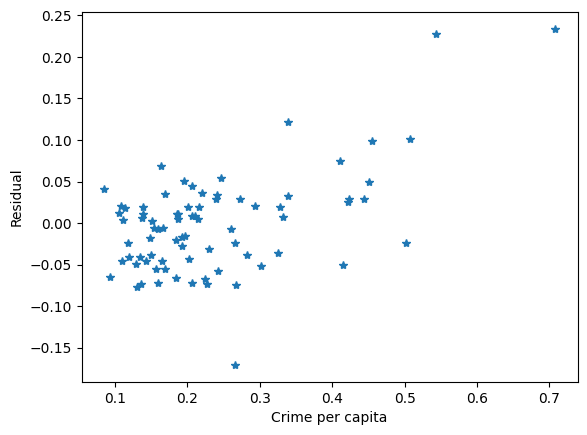

Coef [-0.02768703 -0.02143072 -0.0102778  -0.01615442  0.00092079  0.00413264
  0.02698947  0.02734108  0.02314699  0.13391898  0.01913535  0.05780952
  0.07926429  0.05546632  0.08753638  0.06938954  0.12115568  0.01849478]
Bias 1.7910386006457317


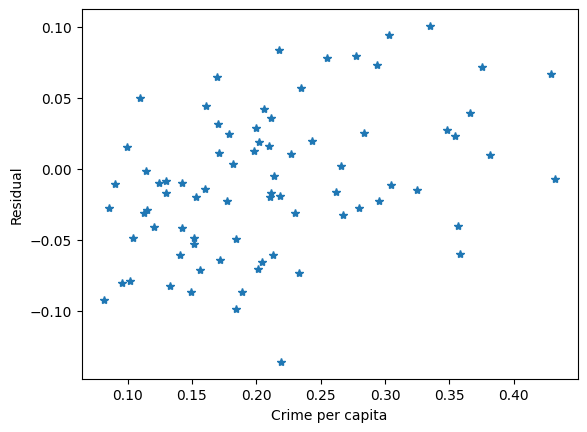

Coef [-0.02864606 -0.00138052  0.00946724 -0.00090159  0.00083898  0.0053121
  0.02571354  0.02729596  0.02221225  0.13671567  0.02215846  0.03758443
  0.07846631  0.05972839  0.09498192  0.0683295   0.12935689  0.01443606]
Bias -0.2442715293559479


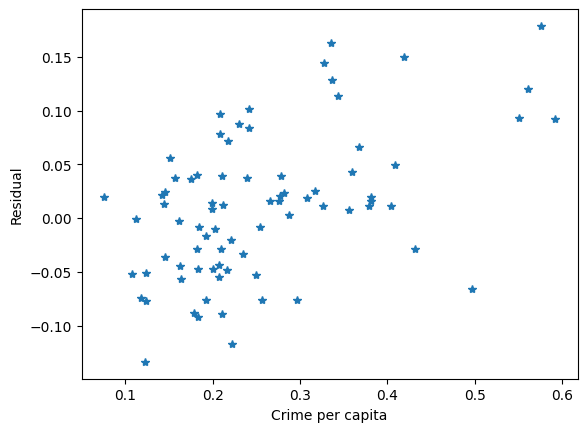

Average MSE train error: 0.003229495591936552
Average MSE test error: 0.0035440727135344395
Average MAE train error: 0.0435415119663917
Average MAE test error: 0.04555661121587067
Average MAPE train error: 0.21142035918058485
Average MAPE test error: 0.22083358098435105

Average value in Y: 0.2338318098958433
STD value in Y: 0.1132114802988695


Lasso
Coef [ 0.        -0.0023014  0.         0.         0.         0.
  0.        -0.        -0.         0.        -0.         0.
  0.         0.         0.         0.         0.        -0.       ]
Bias 0.38265943228377164


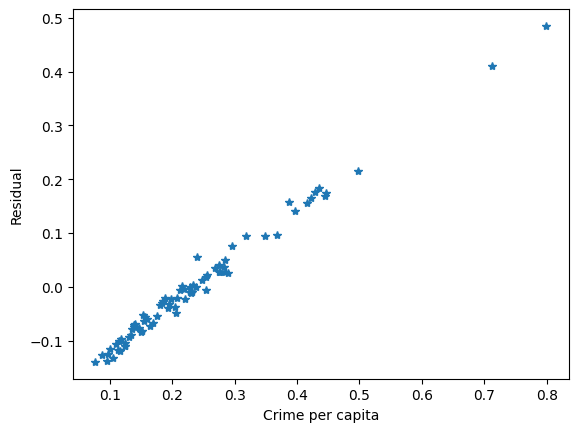

Coef [ 0.         -0.          0.00332771 -0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.        ]
Bias 0.11931200955371427


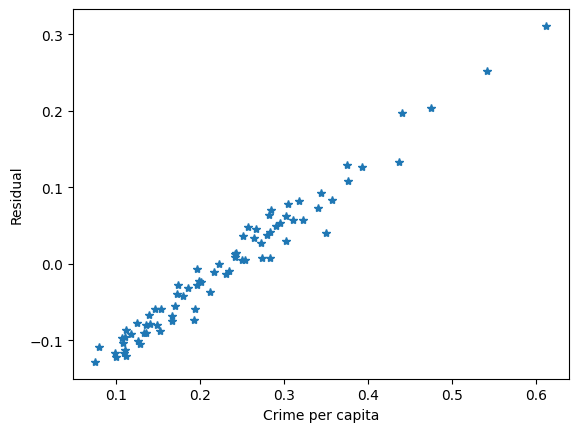

Coef [ 0.         -0.00125301  0.00170106  0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.          0.          0.         -0.        ]
Bias 0.25573214336330474


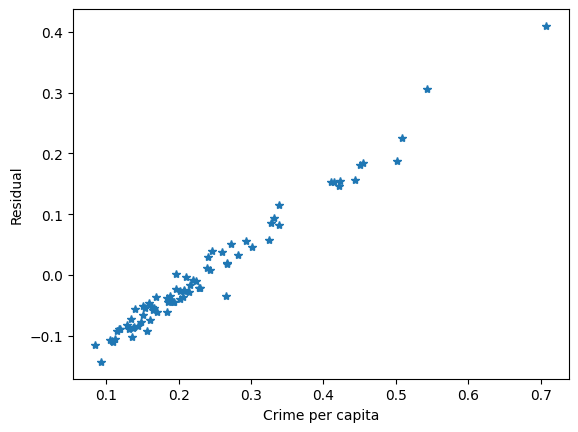

Coef [ 0.         -0.          0.00408494 -0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.        ]
Bias 0.09691112133218044


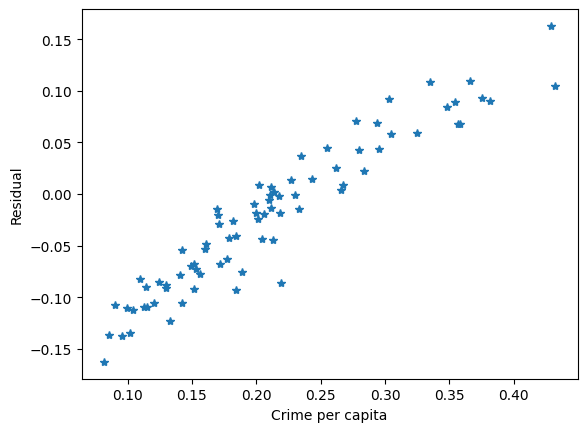

Coef [ 0.         -0.          0.00294001 -0.          0.          0.
  0.         -0.         -0.          0.         -0.         -0.
  0.          0.          0.         -0.          0.         -0.        ]
Bias 0.1271395153722031


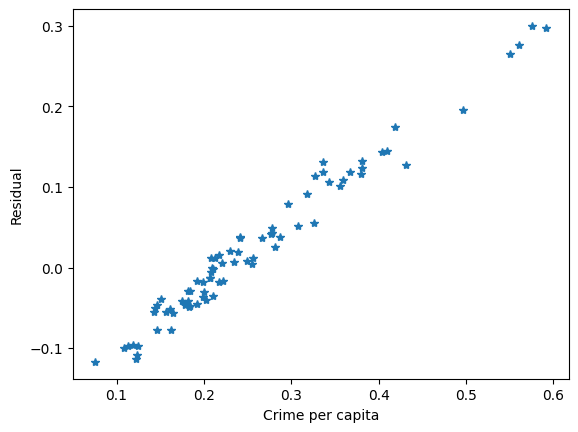

Average MSE train error: 0.008978265457446274
Average MSE test error: 0.009312748135997815
Average MAE train error: 0.07206910125497223
Average MAE test error: 0.07286101232208513
Average MAPE train error: 0.37054577197984456
Average MAPE test error: 0.3737297793827749

Average value in Y: 0.2338318098958433
STD value in Y: 0.1132114802988695




In [56]:
train_pipeline(
    model_name='LR',
    data=relative_gemeente_features,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

train_pipeline(
    model_name='Ridge',
    data=relative_gemeente_features,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

train_pipeline(
    model_name='Lasso',
    data=relative_gemeente_features,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

### Nested cross-validation

Let's use nested cross validation to ensure that we do not use a weak/simple test set. Nested cross validation first splits the data into train-validation and test set, then the train and validation set are split. We fit on the train set We did this since our errors were quiet low with the normal cross-validation.

In [57]:
def train_pipeline_advanced(model_name: str, data: pd.DataFrame, col_name_to_predict: str, column_to_drop: str, folds: int = 5, seed: int = 21, plot_residuals: bool = False):
    """
    Training and validation pipeline for our models

    Args:
        model_name (str): name of the linear model to use
        data (pd.DataFrame): dataframe containing data (features and real value that needs to be regressed)
        col_name_to_predict (str): the column name of the value that needs to be regressed
        column_to_drop (str): additional columns to drop, e.g. 'index'
        folds (int, optional): the number of folds to perform. Defaults to 5.
        seed (int, optional): the random state or seed. Defaults to 21.
        plot_residuals (bool, optional): enables/disables plotting of residuals. Defaults to False.
    """

    # Generate folds and make the X-Y split of the data
    k_folds_outer = KFold(n_splits=folds, shuffle=True, random_state=seed)
    k_folds_inner = KFold(n_splits=folds, shuffle=True, random_state=seed)
    X = data.drop(columns=[col_name_to_predict])
    X = X.drop(columns=column_to_drop)
    Y = data[col_name_to_predict]

    # Error metrics are MSE and MAE
    errors = {'mse':{'train': [], 'validation': [], 'test': []}, 'mae':{'train': [], 'validation': [], 'test': []}}

    print(model_name)

    # i is folder number
    # x_index is a list with x indices (so train or test indices)
    for i, (train_validation_index, test_index) in enumerate(k_folds_outer.split(X)):
        #print('Busy with fold', i)

        # Get train and validation data
        X_train_validation = X.iloc[train_validation_index]
        y_train_validation = Y.iloc[train_validation_index]

        # Get test data
        X_test = X.iloc[test_index]
        y_test = Y.iloc[test_index]

        for j, (train_index, validation_index) in enumerate(k_folds_inner.split(X_train_validation)):

            if(model_name == 'Ridge'):
                model=Ridge()
            elif(model_name == 'Lasso'):
                model=Lasso()
            else:#(model_name == 'LR'):
                model=LinearRegression()

            # Get train data
            X_train = X_train_validation.iloc[train_index]
            y_train = y_train_validation.iloc[train_index]

            # Get validation data
            X_validation = X_train_validation.iloc[validation_index]
            y_validation = y_train_validation.iloc[validation_index]

            # Fit the model
            model.fit(X=X_train, y=y_train)
            print('Coef', model.coef_)
            print('Bias', model.intercept_)

            # Predict training data
            y_pred_train = model.predict(X=X_train)
            mse_train = MSE(y_true=y_train, y_pred=y_pred_train)
            mae_train = MAE(y_true=y_train, y_pred=y_pred_train)
            errors['mse']['train'].append(mse_train)
            errors['mae']['train'].append(mae_train)

            # Predict validation data
            y_pred_validation = model.predict(X=X_validation)
            mse_validation = MSE(y_true=y_validation, y_pred=y_pred_validation)
            mae_validation = MAE(y_true=y_validation, y_pred=y_pred_validation)
            errors['mse']['validation'].append(mse_validation)
            errors['mae']['validation'].append(mae_validation)

            # Predict testing data
            y_pred_test = model.predict(X=X_test)
            #print(y_pred_test)
            mse_test = MSE(y_true=y_test, y_pred=y_pred_test)
            mae_test = MAE(y_true=y_test, y_pred=y_pred_test)
            errors['mse']['test'].append(mse_test)
            errors['mae']['test'].append(mae_test)


        # Residuals plotting
        if plot_residuals:
            residuals = y_test - y_pred_test
            plt.plot(y_test, residuals, '*')
            plt.xlabel("Crime per capita")
            plt.ylabel("Residual")
            plt.show()

    #print(errors)
    print('Average MSE train error:', np.average(errors['mse']['train']))
    print('Average MSE validation error:', np.average(errors['mse']['validation']))
    print('Average MSE test error:', np.average(errors['mse']['test']))
    print('Average MAE train error:', np.average(errors['mae']['train']))
    print('Average MAE validation error:', np.average(errors['mae']['validation']))
    print('Average MAE test error:', np.average(errors['mae']['test']))
    print()
    print('Average value in Y:', np.average(Y))
    print('STD value in Y:', np.std(Y))
    print()
    print()

Here is our relaxed problem again.

LR
Coef [ 2.71382519e+00 -6.92382597e+00 -6.21618320e+00 -6.35537431e+00
  1.10746893e+04  3.10599547e-01  1.04008469e+03  5.16606594e+00
  7.78345855e+00  1.70969211e+01  8.56779150e+00  1.14775969e+01
  1.45965034e+01  1.25201520e+01  1.63809230e+01  1.01960627e+01
  1.71206357e+01  4.66118955e+00]
Bias 649.9037652877697
Coef [ 1.07164056e+01 -3.93932951e+00 -3.20201082e+00 -3.55064447e+00
  1.15414164e+04  4.16063009e-01  1.22173162e+03  3.88098050e+00
  7.78175187e+00  1.59771923e+01  7.15470919e+00  1.06549559e+01
  1.35436820e+01  1.08041193e+01  1.84836933e+01  9.44194945e+00
  1.43882376e+01  4.26404873e+00]
Bias 344.8718801310219
Coef [ 7.94662419e+00 -1.07175279e+01 -9.96355111e+00 -9.87294793e+00
  9.20807706e+03  3.33914255e-01  9.30272812e+02  5.47250079e+00
  6.61712156e+00  2.67146191e+01  8.77366620e+00  1.13190559e+01
  1.36603666e+01  1.18652953e+01  1.89525668e+01  1.13618233e+01
  1.67321867e+01  5.33848239e+00]
Bias 1028.7490637596811
Coef [-1.21962965e+00  2.62894

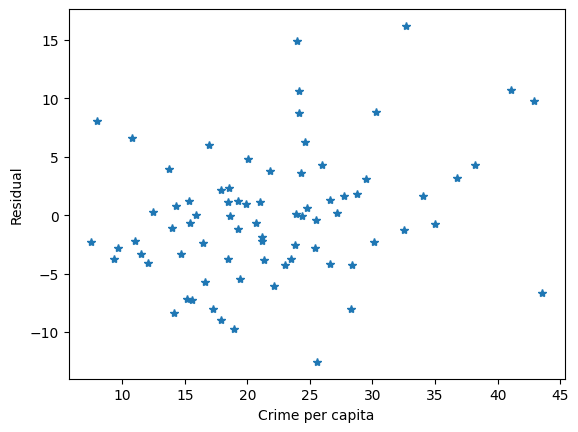

Coef [ 1.21165828e+01 -6.66193048e+00 -6.03056646e+00 -5.65537646e+00
  7.76209270e+03  2.94143325e-01  1.20361145e+03  2.21238858e+00
  6.85781078e+00  1.60526740e+01  8.50363404e+00  1.11825006e+01
  1.36639987e+01  1.20320126e+01  1.58266067e+01  1.07516093e+01
  1.43319054e+01  2.42801452e+00]
Bias 625.687738142193
Coef [ 6.71889522e+00 -1.46211152e+01 -1.39057931e+01 -1.37671830e+01
  8.22624709e+03  4.40784841e-01  8.72376528e+02  3.96292583e+00
  6.98335465e+00  1.85260885e+01  7.52085371e+00  9.70434811e+00
  1.28630164e+01  1.10507643e+01  1.39398496e+01  1.05815568e+01
  1.62025381e+01  3.78083005e+00]
Bias 1419.0807875473633
Coef [-1.30255549e+01 -1.88973832e+00 -1.17325351e+00 -1.30604350e+00
  7.33304426e+03  4.24246389e-01  9.85842745e+02  4.57187558e+00
  6.16262927e+00  1.84166402e+01  8.59830850e+00  1.11074750e+01
  1.41170099e+01  1.22762944e+01  1.79673903e+01  1.10683658e+01
  1.60138182e+01  4.38213841e+00]
Bias 144.78926787121674
Coef [-9.70814576e+00 -3.67628032

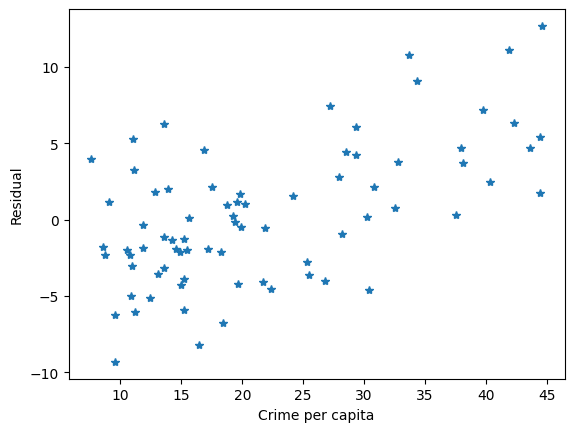

Coef [2.12524631e+01 1.10329764e+00 1.67927747e+00 2.27926344e+00
 9.66462744e+03 2.95206315e-01 1.14061691e+03 3.16795689e+00
 6.62328053e+00 1.09524878e+01 7.99209441e+00 1.10500173e+01
 1.31323135e+01 1.17438816e+01 1.24268160e+01 9.99001120e+00
 1.43478317e+01 3.19117615e+00]
Bias -148.9417388608337
Coef [ 5.12637177e+00 -3.68407998e-01  3.22832180e-01 -2.37886777e-02
  9.39962078e+03  4.31687635e-01  1.11228117e+03  2.24405925e+00
  5.10106265e+00  1.04405287e+01  7.36749595e+00  1.01170045e+01
  1.17528490e+01  1.16030239e+01  1.05033427e+01  8.85637517e+00
  1.56050126e+01  3.29441697e+00]
Bias -8.068926060532174
Coef [ 8.48141154e+00 -8.85710614e+00 -8.13730389e+00 -7.89675304e+00
  8.65652134e+03  4.03866011e-01  1.16853784e+03  2.61937693e+00
  6.14292298e+00  1.14212490e+01  7.26465142e+00  1.07133188e+01
  1.25832350e+01  1.07799498e+01  1.18936046e+01  1.00923070e+01
  1.47370371e+01  3.42397165e+00]
Bias 839.3437672397238
Coef [ 1.64177458e+01 -6.80276544e-01  2.41858376e

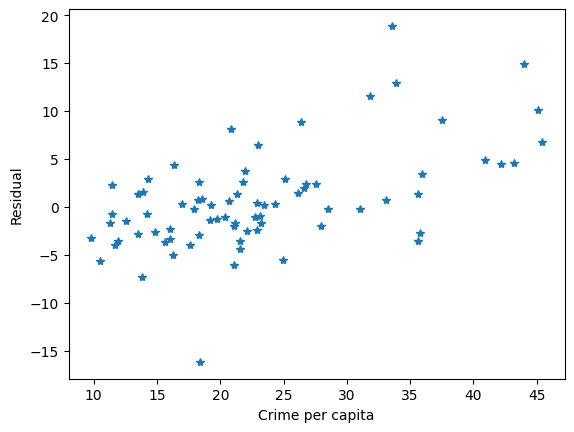

Coef [ 1.38590081e+01 -2.72137554e+00 -1.98266003e+00 -2.17717684e+00
  8.61342124e+03  3.82995592e-01  8.54037301e+02  3.33843664e+00
  6.30665508e+00  1.40781893e+01  7.51213928e+00  1.10534778e+01
  1.23870632e+01  1.09615756e+01  1.28841381e+01  9.96837399e+00
  1.61077770e+01  4.31515763e+00]
Bias 230.37617667961737
Coef [ 1.07314343e+01 -1.16225885e+00 -4.02764945e-01 -3.54715093e-01
  7.25686194e+03  4.12027694e-01  7.88085782e+02  3.91000752e+00
  6.27592288e+00  1.71098164e+01  8.15490826e+00  9.89178304e+00
  1.25699612e+01  1.22391019e+01  1.56092362e+01  1.12514226e+01
  1.70421412e+01  4.45532808e+00]
Bias 73.88397719055236
Coef [ 1.10691316e+01 -5.14744268e+00 -4.41743675e+00 -4.20559421e+00
  8.83343472e+03  3.76501024e-01  8.83206131e+02  3.39584654e+00
  6.25301178e+00  1.48802449e+01  7.28891295e+00  1.05458492e+01
  1.30392339e+01  1.15231236e+01  1.60704028e+01  1.06557975e+01
  1.67117425e+01  3.81556602e+00]
Bias 472.697264675088
Coef [ 2.64277202e+01 -5.35220052e

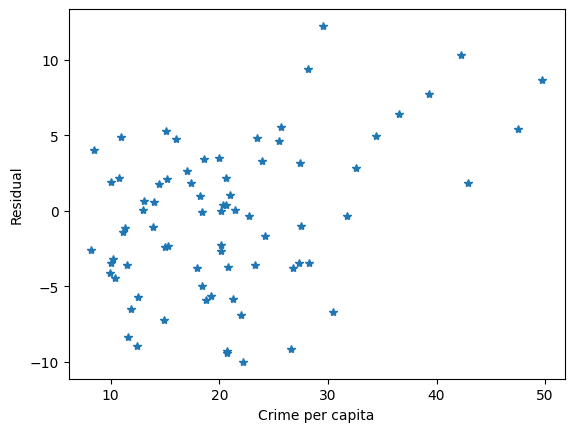

Coef [9.85155267e+00 4.42492724e+00 5.10500183e+00 4.63785276e+00
 8.32980160e+03 3.78674306e-01 1.07973977e+03 3.44375476e+00
 7.57372439e+00 1.45048039e+01 8.57361664e+00 1.11090814e+01
 1.29895515e+01 1.30078966e+01 1.56962550e+01 1.13454744e+01
 1.53249566e+01 3.00467617e+00]
Bias -485.50507393184785
Coef [1.19053958e+01 1.08617177e+00 1.82798687e+00 1.39633209e+00
 7.30186251e+03 4.30465154e-01 1.01814253e+03 4.27715591e+00
 7.38415565e+00 1.47479097e+01 8.20661711e+00 1.09664356e+01
 1.25442049e+01 1.14649535e+01 1.41088114e+01 1.19415605e+01
 1.57147495e+01 4.50445899e+00]
Bias -154.29555652045337
Coef [ 1.73371082e+01 -1.82623315e+00 -1.08701685e+00 -2.36982104e+00
  7.11889944e+03  5.60326620e-01  9.84215639e+02  5.34380914e+00
  5.88584739e+00  1.56996535e+01  7.03286076e+00  9.45199603e+00
  1.13062743e+01  9.97971524e+00  1.64309021e+01  1.01161097e+01
  1.49229017e+01  3.78592963e+00]
Bias 134.77638397643486
Coef [8.44490375e+00 3.32718115e+00 4.03977279e+00 3.45139091e+00

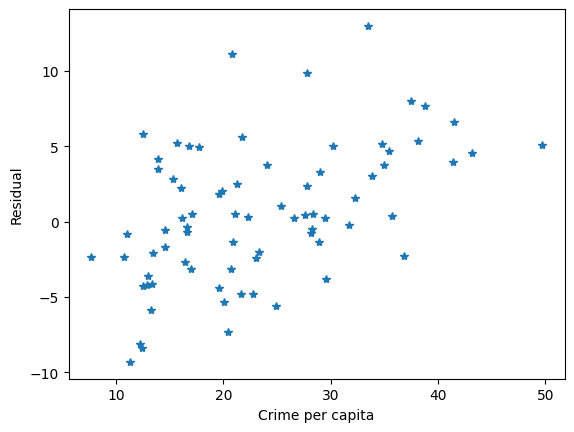

Average MSE train error: 19.97177771440726
Average MSE validation error: 24.194674857678496
Average MSE test error: 24.900840332058284
Average MAE train error: 3.4984600782043187
Average MAE validation error: 3.800262583687058
Average MAE test error: 3.8383861311951075

Average value in Y: 22.22275266334029
STD value in Y: 9.26695742014054


Ridge
Coef [-0.42027751 -0.59030819  0.37272977 -0.58323087  0.04347686  0.330544
  0.74010591  2.07589954  1.89327886  9.53973019  2.19234318  4.97247014
  7.1722295   3.95922449  7.96530846  5.07292996 11.78145461  0.14920486]
Bias 32.589957739368444
Coef [ 0.15195378 -0.62062007  0.36317218 -0.49779911  0.0507405   0.43400889
  1.00374088  1.03506294  1.61262347  8.85184937  0.57275538  3.56167345
  5.78784966  1.92608749  9.31813009  4.4929521   9.26766113 -0.38502855]
Bias 32.43958784599306
Coef [ 0.30027072 -1.29550603 -0.32333166 -1.09276635  0.03057601  0.41855958
  0.71419068  1.89548826  0.59467435 12.05974042  2.50469808  3.87486566
  5.

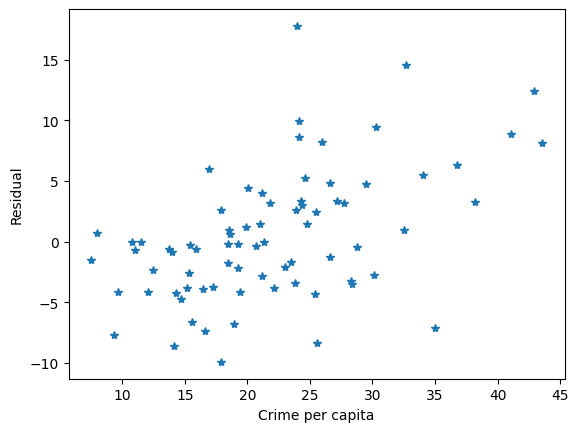

Coef [-0.14289305 -0.7904017   0.09972232 -0.58008351  0.03982084  0.38998711
  0.91483668 -0.29831378  1.41933697  7.59217202  1.14709113  2.97694637
  5.81513317  3.53878993  6.86953211  4.88886151  8.94359144 -0.90870304]
Bias 54.11476777131266
Coef [ 0.44807391 -1.58634265 -0.65405986 -1.20979563  0.04399109  0.50131024
  0.76186222  0.13489763  1.07907399  9.0699458   0.68497035  2.40058249
  5.82154546  2.67590137  6.00520279  5.10515113 10.30585371 -1.03946297]
Bias 128.66057434542617
Coef [-1.72436588 -0.61543313  0.27389259 -1.22435445  0.03265477  0.44355339
  0.80266201  0.9254657  -0.32043711  8.41062429  1.04301081  2.58286761
  5.3072346   2.59381846  9.22047     5.06105956  9.81508046 -1.34822415]
Bias 35.321294261923306
Coef [-1.16427757 -0.32290498  0.59231578 -0.35575522  0.03713797  0.35626262
  0.85437533  0.59556998 -0.39421464  7.48571874  0.78299708  3.57618838
  5.4424092   2.48448305  8.25175399  5.00341302  9.44638176 -1.38121707]
Bias 8.018358793537466
Coef [

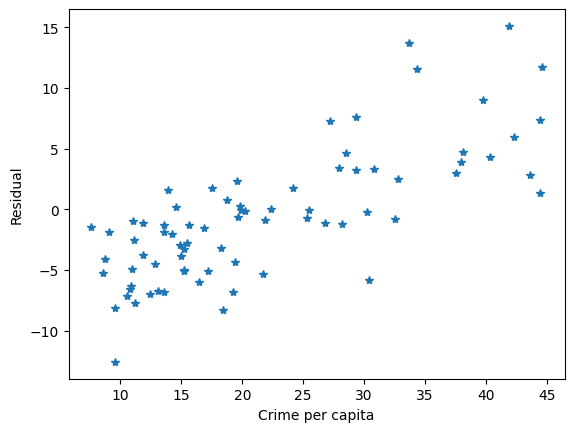

Coef [ 1.00700197 -0.55211752  0.33606892 -0.40887412  0.04455838  0.45888154
  0.76128427  1.32727888  1.44715505  4.59000013  1.439377    3.84658443
  6.7443076   4.3493739   4.64711232  5.35197203 10.54721367  0.19093297]
Bias 26.91446271748776
Coef [ 0.4240313  -0.14037695  0.78273547 -0.95065092  0.04818446  0.49954787
  0.87416418  0.74084043  0.06197129  4.74140099  1.47947     4.0768092
  5.84549502  4.29391047  3.34081013  4.43097387 11.4719127  -0.22140878]
Bias -15.72822229807715
Coef [ 0.94681933 -0.77462984  0.17559873 -1.25509921  0.04299457  0.44549524
  0.86369967  1.04286058  0.90398638  4.38579635  0.91072085  4.44963175
  6.25736477  2.56391195  4.44714141  5.77127344 10.35346282 -0.18234708]
Bias 48.275449846279955
Coef [ 0.85090256 -0.61096424  0.32185955 -0.73460832  0.04856225  0.40344934
  0.83275022  1.78676572  0.51749914  3.31900778  1.39145726  5.46593864
  6.64706444  4.43603153  6.67629103  5.90179947 10.17206265 -0.3409164 ]
Bias 33.392077206530274
Coef [

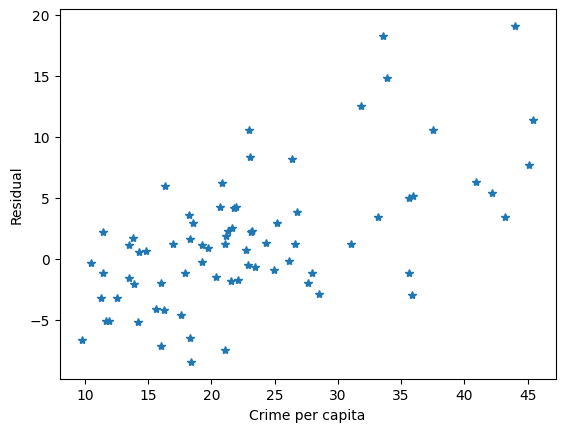

Coef [ 1.08650475 -0.33236376  0.61659945  0.01801845  0.0406781   0.43459053
  0.68473879  0.42499568  1.10275658  7.57725191  1.4858955   4.7841327
  6.17684669  3.69392462  5.48052497  5.19608302 10.4806574   0.17399872]
Bias 4.047366632669625
Coef [ 1.19833545 -0.16258441  0.78629561  0.14701791  0.03161294  0.47392169
  0.57592173 -0.05243332  0.12818056  9.36573857  1.35633507  2.66763313
  5.65078183  4.32169533  7.59323225  5.8017077  10.46851066  0.31749841]
Bias -13.80262239119686
Coef [ 1.25481234 -0.7239531   0.22974447 -0.24975129  0.04084724  0.45322324
  0.7709426  -0.21175278  0.37814147  7.62406326  0.37487822  3.28227409
  5.6540841   3.34172759  8.013611    5.28681026 10.46682801  0.31319277]
Bias 42.87132701350831
Coef [ 1.70918533e+00 -3.97928854e-01  5.95587626e-01 -5.46194302e-01
  3.59173794e-02  3.59330742e-01  5.72007731e-01  7.41391934e-01
  1.08428638e+00  6.94511266e+00  6.14948755e-01  4.27539722e+00
  6.20892742e+00  3.79124549e+00  6.42762175e+00  6.0788

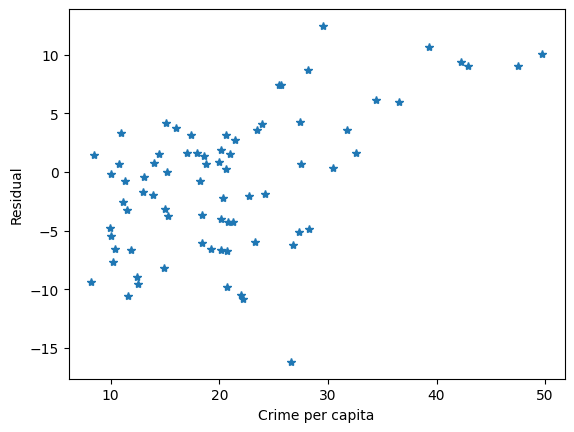

Coef [ 1.17500503  0.64531675  1.56349136  0.36612756  0.03385645  0.45795291
  0.79283597  1.07205459  1.82525602  8.91914118  2.14204263  3.74976138
  5.54035577  5.34191252  7.70900358  6.57694722 10.61654992 -0.06883831]
Bias -93.55992364181022
Coef [0.92495305 0.410031   1.38843962 0.41988495 0.03449749 0.52249471
 0.8387449  0.47265939 0.81540789 7.26593152 0.98154426 3.30860678
 4.47636684 2.4132549  6.05712554 6.14524747 9.93905003 0.1857248 ]
Bias -73.49315957581379
Coef [ 1.40779551e+00  2.87029257e-01  1.25617205e+00 -1.10632066e+00
  2.97548361e-02  7.14764731e-01  7.76948921e-01  1.70348993e+00
 -2.39390261e-04  7.54045743e+00  4.96371070e-01  2.77417578e+00
  4.47480828e+00  1.99326476e+00  8.63769912e+00  5.12448987e+00
  1.05157018e+01 -2.43039599e-01]
Bias -66.21303749463367
Coef [7.68383889e-01 2.93487166e-01 1.23607760e+00 5.87656631e-03
 3.86033427e-02 4.50725064e-01 8.87154462e-01 6.80352155e-01
 1.03237167e-01 8.34062041e+00 1.63075040e+00 2.61564295e+00
 5.704316

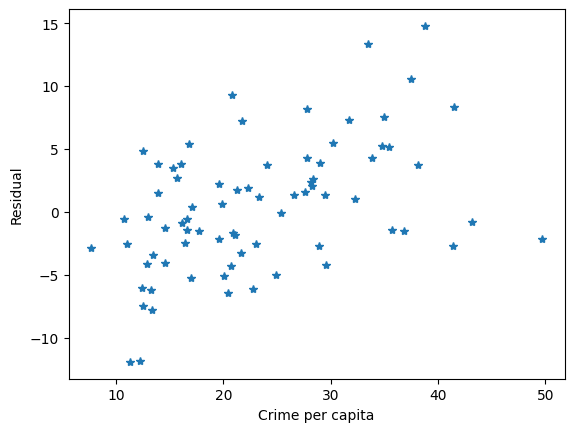

Average MSE train error: 26.13120158866903
Average MSE validation error: 30.153015303501732
Average MSE test error: 30.47597334682157
Average MAE train error: 3.965228644893326
Average MAE validation error: 4.218630771462125
Average MAE test error: 4.260365417306971

Average value in Y: 22.22275266334029
STD value in Y: 9.26695742014054


Lasso
Coef [ 0.         -0.          0.92097594 -0.          0.          0.42564861
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -23.911640422157035
Coef [ 0.         -0.00778845  0.93745352 -0.          0.          0.42399129
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -23.732484111695445
Coef [ 0.         -0.          0.93091092 -0.          0.          0.42922731
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          

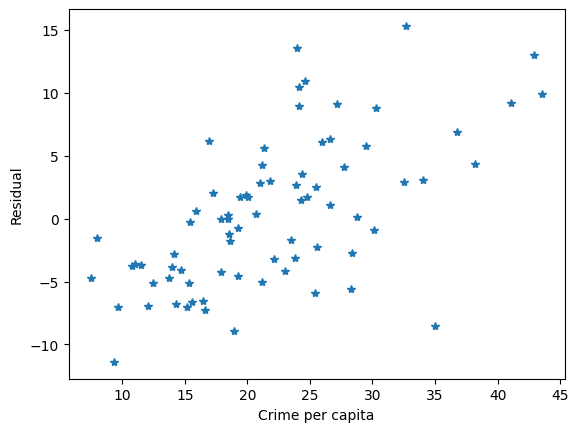

Coef [ 0.         -0.          0.81209817 -0.          0.          0.45318962
  0.         -0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.        ]
Bias -20.791793771794648
Coef [ 0.         -0.          0.88831471 -0.          0.          0.49174412
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -24.466995886940953
Coef [ 0.         -0.          0.83013346 -0.          0.          0.42962804
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -20.77317082768875
Coef [ 0.         -0.          0.8419314  -0.          0.          0.39723114
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -19.854823004839105
Coef [ 0.         -0.          0.

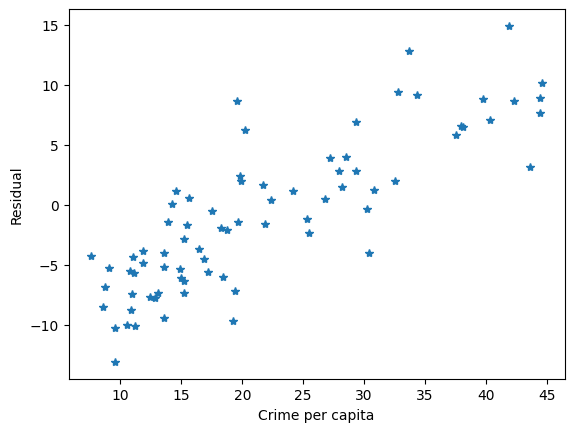

Coef [ 0.         -0.          0.86186693 -0.          0.          0.53955151
  0.         -0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.        ]
Bias -26.04502656002076
Coef [ 0.         -0.          0.91513856 -0.          0.          0.54128014
  0.         -0.         -0.          0.         -0.          0.
  0.          0.         -0.          0.          0.         -0.        ]
Bias -27.90462308547795
Coef [ 0.         -0.          0.88846838 -0.          0.          0.46440727
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -24.309925814720906
Coef [ 0.         -0.          0.88971507 -0.          0.          0.49264644
  0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.          0.          0.         -0.        ]
Bias -25.10977654366008
Coef [ 0.         -0.          0.88

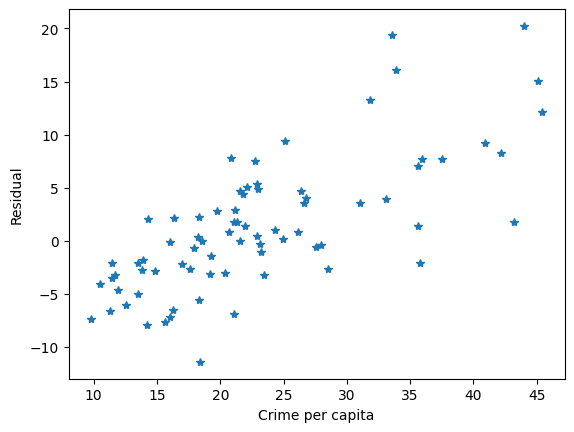

Coef [ 0.         -0.          0.89373684 -0.          0.          0.5112831
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -25.78423842750552
Coef [ 0.         -0.          0.93529733 -0.          0.          0.51090409
  0.         -0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.        ]
Bias -26.778652407045985
Coef [ 0.         -0.0226425   0.88387096 -0.          0.          0.47081439
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -22.22504616999281
Coef [ 0.         -0.          0.95532209 -0.          0.          0.44911196
  0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.          0.          0.         -0.        ]
Bias -25.54205820178464
Coef [ 0.         -0.26796851  0.633

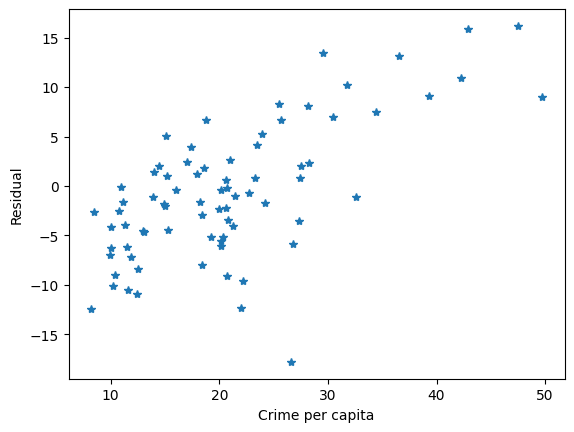

Coef [ 0.         -0.          0.87913414 -0.          0.          0.53524331
  0.         -0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.        ]
Bias -26.202405460057793
Coef [ 0.         -0.          0.92029808 -0.          0.          0.49689429
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -26.226266795546515
Coef [ 0.         -0.          0.91937668 -0.          0.          0.62715527
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.        ]
Bias -30.673016877568028
Coef [ 0.         -0.          0.88157826 -0.          0.          0.45580455
  0.         -0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.        ]
Bias -23.39098259337539
Coef [ 0.         -0.          0.

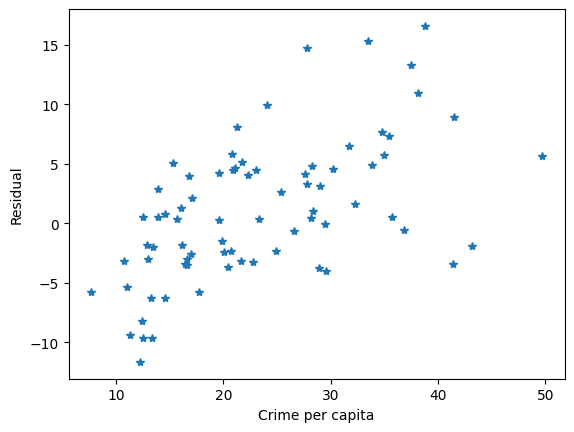

Average MSE train error: 37.807188789963796
Average MSE validation error: 38.652527007685016
Average MSE test error: 39.231707159464584
Average MAE train error: 4.87358911118738
Average MAE validation error: 4.9150215344852715
Average MAE test error: 4.963975510667627

Average value in Y: 22.22275266334029
STD value in Y: 9.26695742014054




In [58]:
train_pipeline_advanced(
    model_name='LR',
    data=relative_crimes_without_cities,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

train_pipeline_advanced(
    model_name='Ridge',
    data=relative_crimes_without_cities,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

train_pipeline_advanced(
    model_name='Lasso',
    data=relative_crimes_without_cities,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

Here are all the cities.

LR
Coef [ 1.52155888e-01 -1.08808467e-01 -1.00387456e-01 -9.46670229e-02
  6.32563707e+01  3.25664001e-03  8.25903238e+00  3.91074718e-02
  7.08159453e-02  2.13810342e-01  8.71580675e-02  1.24637078e-01
  1.33484066e-01  1.33067112e-01  1.34778511e-01  1.25696616e-01
  1.76023341e-01  4.89814489e-02]
Bias 10.440903853289365
Coef [ 3.01163287e-02 -2.34825883e-01 -2.26020195e-01 -2.24854912e-01
  7.32669827e+01  3.03252415e-03  7.88059305e+00  3.51051498e-02
  5.67892077e-02  1.84274217e-01  7.64149575e-02  1.13575732e-01
  1.30584272e-01  1.37165417e-01  1.63251948e-01  1.23751684e-01
  1.63773136e-01  4.58466090e-02]
Bias 23.05327507028854
Coef [ 1.27258446e-01 -1.74861814e-01 -1.65778408e-01 -1.61844220e-01
  7.41392502e+01  3.90602761e-03  9.37553622e+00  6.33581057e-02
  6.99759910e-02  2.05280192e-01  8.71902811e-02  1.34852473e-01
  1.36387586e-01  1.39353462e-01  1.67530108e-01  1.26797086e-01
  1.80148454e-01  5.28943590e-02]
Bias 16.98114333604727
Coef [ 2.65827352e-01 -1.81230

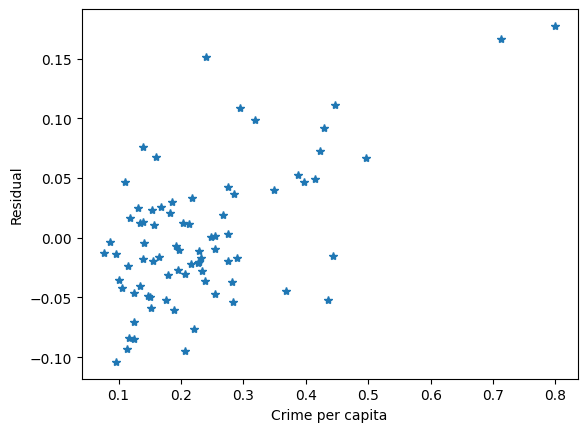

Coef [-8.79469504e-02  6.30814480e-02  7.11031410e-02  7.33178522e-02
  9.07456745e+01  4.78885249e-03  1.33308002e+01  3.28634457e-02
  7.01943590e-02  1.59763687e-01  8.23731324e-02  1.19064082e-01
  1.41770119e-01  1.34713985e-01  1.67019748e-01  1.05895303e-01
  1.74120664e-01  3.35928204e-02]
Bias -6.855572244149481
Coef [-8.23531023e-02 -1.16247162e-01 -1.07390353e-01 -1.07184092e-01
  8.93515185e+01  4.01805549e-03  9.75799020e+00  3.56344336e-02
  6.08724581e-02  1.74454917e-01  6.84228519e-02  1.03462740e-01
  1.34695071e-01  1.28819278e-01  1.70977691e-01  1.12576153e-01
  1.47869396e-01  3.24284941e-02]
Bias 11.13523101696711
Coef [-1.51196713e-01 -9.48826592e-02 -8.65249251e-02 -8.84172745e-02
  7.34537450e+01  4.81491869e-03  1.11120142e+01  5.23324023e-02
  7.05788146e-02  1.99981522e-01  8.94407641e-02  1.23207265e-01
  1.48730304e-01  1.48098538e-01  1.68656784e-01  1.16028913e-01
  1.73485600e-01  5.00361425e-02]
Bias 8.962585839135306
Coef [-1.17395998e-01 -6.35643193

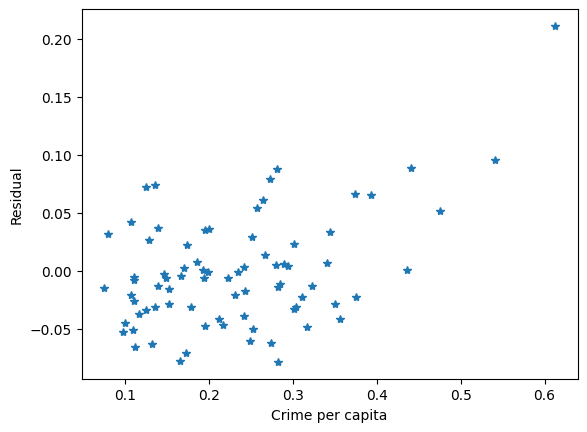

Coef [ 1.36133640e-01 -9.07575235e-02 -8.21803609e-02 -8.18002259e-02
  7.27629077e+01  2.92755969e-03  8.34657469e+00  3.27796061e-02
  5.39267637e-02  1.25479523e-01  5.20092492e-02  1.09823569e-01
  1.26711486e-01  9.08989412e-02  1.31298107e-01  1.01249124e-01
  1.46571447e-01  1.90739639e-02]
Bias 8.666611714097973
Coef [-1.69702247e-01 -7.67732216e-02 -6.78179076e-02 -6.88909505e-02
  9.71843388e+01  4.49986846e-03  1.01084589e+01  6.64441441e-02
  7.53128821e-02  2.27377784e-01  9.27011035e-02  1.27371322e-01
  1.44375861e-01  1.30678924e-01  1.62821424e-01  1.24618670e-01
  1.60291033e-01  5.42430414e-02]
Bias 7.148515319797365
Coef [ 5.81171015e-02 -1.78307338e-01 -1.69171962e-01 -1.69244876e-01
  7.07662743e+01  5.38005830e-03  9.55508352e+00  4.67387044e-02
  6.36785130e-02  2.12429561e-01  8.26907756e-02  1.09337355e-01
  1.30667682e-01  1.13649302e-01  1.57501519e-01  1.11589884e-01
  1.59486579e-01  4.23669535e-02]
Bias 17.289335556321532
Coef [-1.07497935e-01 -1.43294931

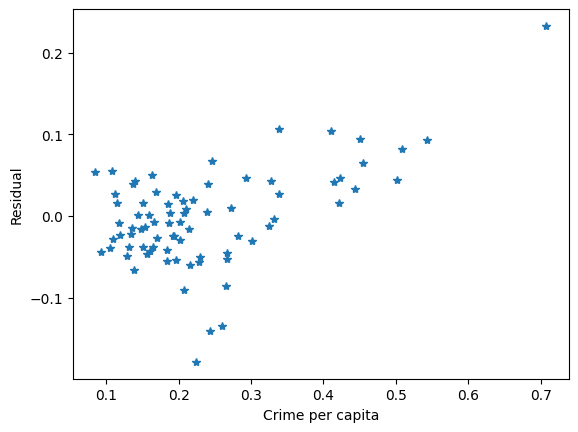

Coef [-1.30254669e-01 -1.49022902e-01 -1.40892298e-01 -1.33989162e-01
  9.90503754e+01  3.65396435e-03  1.33237633e+01  5.13349065e-02
  9.11060890e-02  2.02350678e-01  1.01842953e-01  1.44859374e-01
  1.58893354e-01  1.57004545e-01  1.79567957e-01  1.28831665e-01
  1.77897617e-01  5.61350789e-02]
Bias 14.363554000216446
Coef [-1.69158958e-01 -1.18596330e-01 -1.09304656e-01 -1.08503656e-01
  7.52812311e+01  4.01327247e-03  1.02132401e+01  3.96153861e-02
  6.22492877e-02  1.97241394e-01  6.57498806e-02  1.09377084e-01
  1.25299568e-01  1.18472832e-01  1.44131243e-01  9.63597844e-02
  1.58611060e-01  3.06864011e-02]
Bias 11.360656261604404
Coef [-8.16028404e-02 -1.40275221e-01 -1.31170040e-01 -1.28552642e-01
  7.93036548e+01  3.67428027e-03  1.03218679e+01  4.05747300e-02
  7.07339578e-02  1.58391418e-01  7.64686347e-02  1.23907320e-01
  1.49033161e-01  1.31435626e-01  1.74615139e-01  1.16255643e-01
  1.67933990e-01  3.43893568e-02]
Bias 13.52667395050063
Coef [-1.49510567e-01 -1.7869101

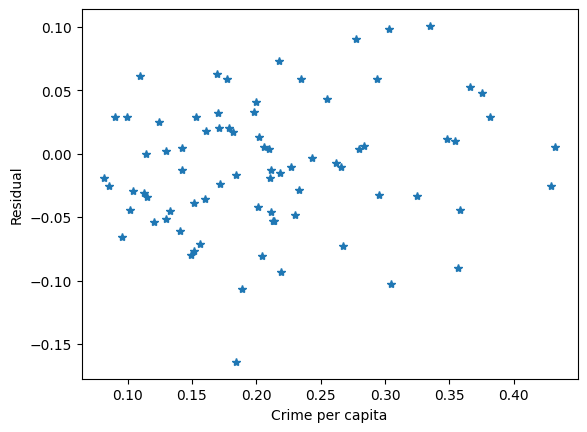

Coef [-2.11519230e-01 -3.71798808e-02 -2.84990142e-02 -3.22169058e-02
  6.54009486e+01  4.95832810e-03  1.20419860e+01  4.02548967e-02
  7.89104500e-02  1.97867386e-01  8.24621632e-02  1.09782032e-01
  1.52660217e-01  1.39537226e-01  1.68887561e-01  1.09057893e-01
  1.75341072e-01  3.30171970e-02]
Bias 3.174242882009661
Coef [-5.88505355e-03  5.21348562e-03  1.42778199e-02  2.36707377e-03
  4.18185838e+01  5.81699702e-03  1.11585178e+01  5.24765702e-02
  7.39704145e-02  2.00044647e-01  8.61216306e-02  1.04039257e-01
  1.44284439e-01  1.25676052e-01  1.68463197e-01  1.16196448e-01
  1.69463030e-01  4.74364668e-02]
Bias -1.0847867289132755
Coef [-1.25309967e-02 -2.14369496e-02 -1.26096067e-02 -1.95771543e-02
  6.31301974e+01  5.15369617e-03  9.89564493e+00  4.15577201e-02
  5.41899801e-02  1.77055742e-01  7.03867695e-02  8.54632557e-02
  1.26796056e-01  1.22005468e-01  1.71827112e-01  9.82014281e-02
  1.70348330e-01  4.14743677e-02]
Bias 1.6284247341755989
Coef [-2.22828760e-01 -4.480554

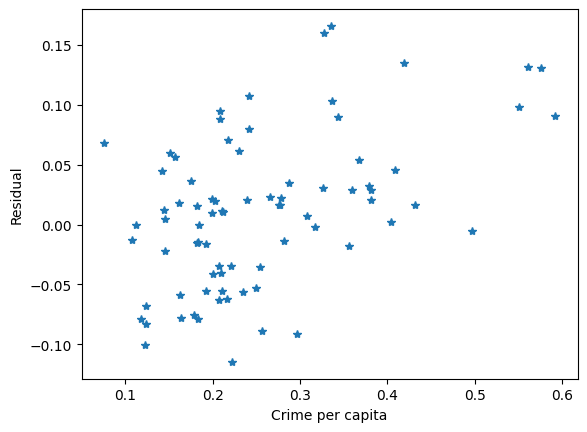

Average MSE train error: 0.0025842362562673487
Average MSE validation error: 0.0031403969368809697
Average MSE test error: 0.0031232104863655684
Average MAE train error: 0.038820261462300915
Average MAE validation error: 0.04255914809413187
Average MAE test error: 0.04250881979676478

Average value in Y: 0.2338318098958433
STD value in Y: 0.1132114802988695


Ridge
Coef [ 0.01444209 -0.01685639 -0.00676735 -0.01028961  0.00023276  0.0036572
  0.00755382  0.00685405  0.01287468  0.13433454  0.02107371  0.05393386
  0.06310958  0.05510285  0.05730557  0.07181302  0.1184135  -0.00091662]
Bias 1.3855330049466628
Coef [ 0.00093561 -0.02344978 -0.01282398 -0.02031799  0.00031138  0.00334127
  0.00690637 -0.00053024 -0.00017087  0.11359987  0.01203921  0.04641197
  0.05759194  0.05757907  0.08542419  0.07222575  0.10620071 -0.0027732 ]
Bias 2.050422825652891
Coef [ 0.01190156 -0.0213937  -0.01039297 -0.01557331  0.0002824   0.00437754
  0.00809727  0.02059317  0.00899919  0.12362558  0.016717

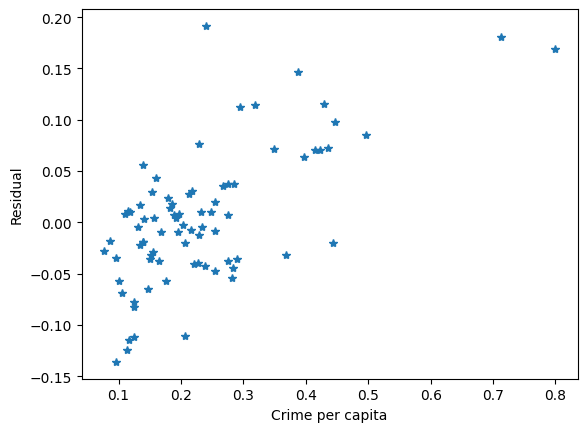

Coef [-0.00409987  0.00052534  0.01120108  0.00289734  0.00048581  0.00524415
  0.01047338  0.0070144   0.00693658  0.10351118  0.00557243  0.04107875
  0.0605606   0.03649997  0.0776999   0.04842435  0.10936566  0.00058664]
Bias -0.411508198667632
Coef [-0.00559274 -0.01311361 -0.00201889 -0.0083189   0.00051697  0.0044174
  0.00904808  0.00050972  0.00036113  0.10213735  0.0003846   0.03073735
  0.06322355  0.04295001  0.0831597   0.05861358  0.09160108 -0.01182166]
Bias 0.9683845916853194
Coef [-0.0096947  -0.01103689 -0.00042346 -0.01266406  0.00043894  0.00548265
  0.0098925   0.01477565  0.00145408  0.12053235  0.01225754  0.02878356
  0.06145131  0.04890993  0.07970814  0.05495978  0.1096342  -0.00361128]
Bias 0.7382845244562262
Coef [-5.08131252e-03 -3.73081898e-03  7.38643121e-03 -2.43255927e-05
  5.48199282e-04  4.69948934e-03  8.60887667e-03  2.73946594e-02
  1.40556533e-02  4.85511933e-02  1.97984083e-02  3.94231586e-02
  7.00591458e-02  4.61795548e-02  5.54568523e-02  5.41

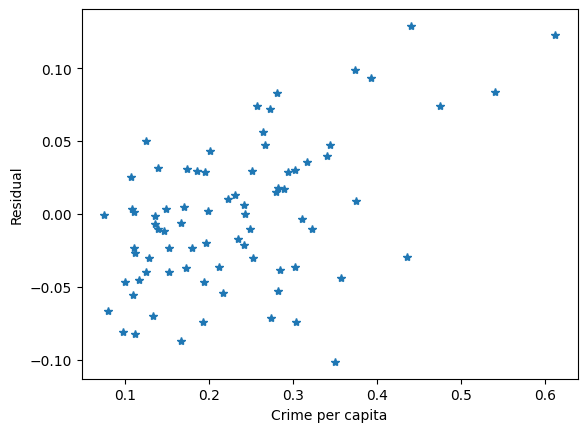

Coef [ 0.0143912  -0.01119883 -0.00073957 -0.00510677  0.00035572  0.00392932
  0.0065099   0.00382215  0.00775327  0.01436018 -0.00408023  0.05267872
  0.06397509  0.02595862  0.0610456   0.05915672  0.10003114 -0.01176421]
Bias 0.8133927105878505
Coef [-0.02366019 -0.00933637  0.00186227 -0.00471871  0.00044477  0.00502388
  0.00825558  0.02300133  0.01157483  0.09233908  0.01310992  0.04749456
  0.05356846  0.03546044  0.07044451  0.06353101  0.09159842  0.00270887]
Bias 0.5626202528400781
Coef [ 0.00146802 -0.0161055  -0.00497327 -0.01100985  0.0004322   0.00647684
  0.00816203  0.00928477  0.00095382  0.09088225  0.01574003  0.03987152
  0.05658932  0.03185229  0.07006828  0.05697827  0.10187405 -0.00084805]
Bias 1.194435605426836
Coef [-0.01526986 -0.01472733 -0.00398697 -0.01295406  0.00040508  0.00533001
  0.00843686  0.00478676 -0.00051675  0.09078004  0.01641745  0.03084911
  0.06199328  0.03431531  0.07267995  0.04740288  0.10724179 -0.01174444]
Bias 1.1092426553365662
Coef 

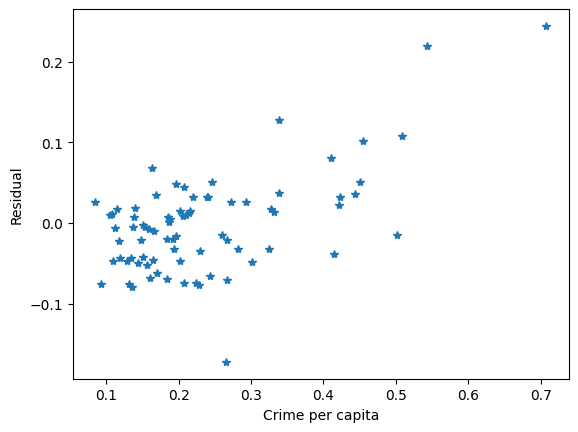

Coef [-0.01667504 -0.01042104  0.00051509 -0.00639498  0.00041487  0.00446621
  0.01053455  0.00618668  0.00629491  0.10764062  0.00410946  0.03687525
  0.04759006  0.03315606  0.06647398  0.04471809  0.09598173  0.00280281]
Bias 0.7060812843029081
Coef [-0.00737417 -0.01027813  0.00109048 -0.00274729  0.0002883   0.00441056
  0.00817129  0.00557018 -0.00103055  0.13302471 -0.00395968  0.03477534
  0.04280838  0.03031143  0.05995875  0.03918743  0.09684964 -0.00594571]
Bias 0.6826807065979383
Coef [-0.00440089 -0.01230116 -0.00117428 -0.00635042  0.00046022  0.00442099
  0.00916551  0.01196908  0.00897856  0.07328451  0.0051584   0.04848023
  0.07297865  0.04342159  0.08120719  0.05810429  0.10490276  0.0068051 ]
Bias 0.8793291341548966
Coef [-0.00940365 -0.01091657  0.00029527 -0.01319742  0.00035562  0.00367223
  0.01061094  0.0198751   0.00998237  0.0921669   0.00364232  0.04540808
  0.06840647  0.03871469  0.0557583   0.0606185   0.10581611 -0.01251544]
Bias 0.7733788921313456
Coef

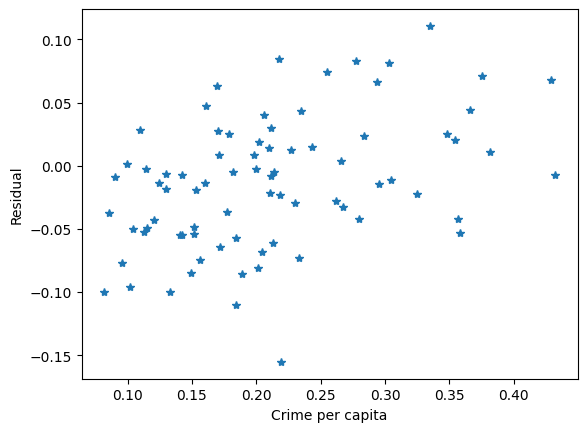

Coef [-0.01417906 -0.00272464  0.00816654 -0.00245353  0.00042656  0.0050547
  0.01056417  0.01022408  0.01397859  0.13875849  0.00273474  0.02749906
  0.0684065   0.04325823  0.07304353  0.05311727  0.10615805 -0.00702473]
Bias -0.08487241799820466
Coef [-1.18381240e-04  2.23988678e-03  1.31937911e-02 -5.16104700e-03
  3.21658657e-04  6.16428197e-03  1.00696636e-02  2.10165414e-02
  1.39916534e-02  1.20840062e-01  1.62968261e-02  2.05076695e-02
  6.78652969e-02  4.14022680e-02  7.95503681e-02  6.25189093e-02
  1.13304082e-01  7.75475718e-03]
Bias -0.623702160771446
Coef [-0.0050587  -0.00188588  0.00893259 -0.00817387  0.00032206  0.00582846
  0.00832307  0.01334806  0.00209646  0.1135875   0.01055118  0.0177744
  0.0540999   0.04457171  0.09457942  0.05212423  0.11906844 -0.0023121 ]
Bias -0.19099648437824984
Coef [-2.47579859e-02 -6.31485258e-03  5.00216565e-03 -4.62644557e-05
  4.32839889e-04  4.87365482e-03  8.71008123e-03  9.57712886e-03
  3.78962967e-03  7.57181102e-02 -5.013451

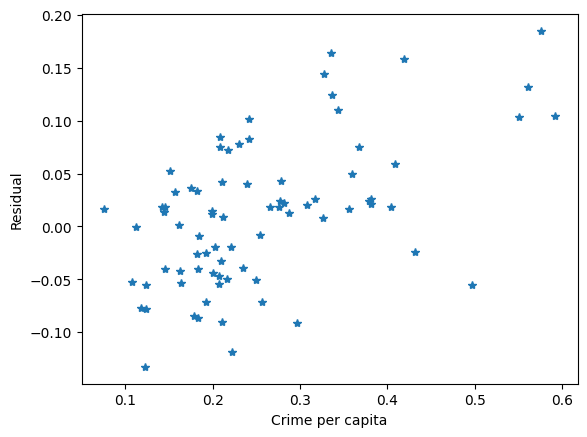

Average MSE train error: 0.0032478375909796627
Average MSE validation error: 0.003741940881742585
Average MSE test error: 0.0036757884147223872
Average MAE train error: 0.04351937615470586
Average MAE validation error: 0.04640753726868059
Average MAE test error: 0.046073351858919705

Average value in Y: 0.2338318098958433
STD value in Y: 0.1132114802988695


Lasso
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.]
Bias 0.23393738968256023
Coef [ 0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.]
Bias 0.23837239454922185
Coef [ 0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.23496115669257184
Coef [ 0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.2326625841659764
Coef [ 0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0.]
Bias 0.2297210178118358


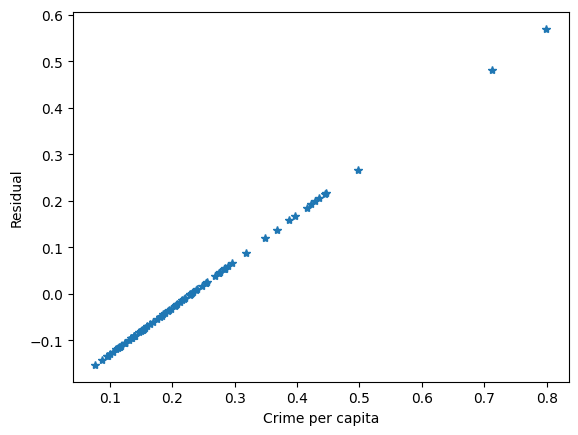

Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.2365091704933766
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0.]
Bias 0.23392135126076385
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0. -0.]
Bias 0.2306155212596176
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.]
Bias 0.2388577086822934
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.23125277442397574


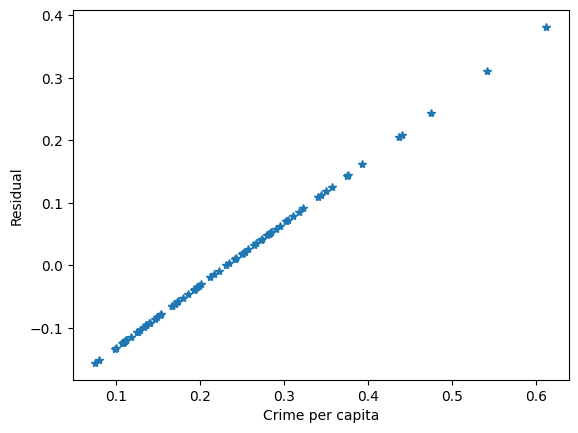

Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.23034995682349643
Coef [ 0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.23736716624529602
Coef [ 0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.]
Bias 0.23478281108619917
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.]
Bias 0.23147720505471842
Coef [ 0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0.  0.  0. -0.]
Bias 0.23341547265802653


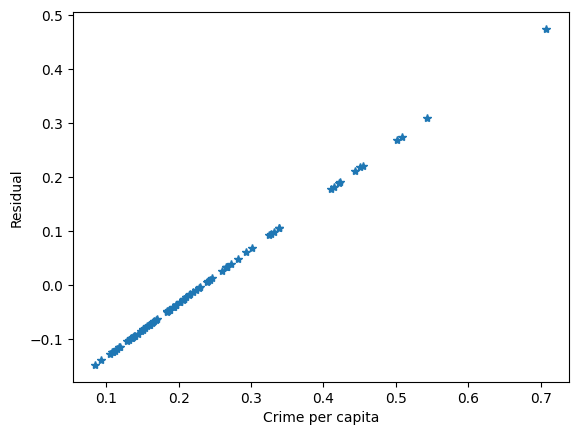

Coef [ 0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.23695637532788355
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.2419242464005662
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.2406947024148044
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
Bias 0.24100821579823634
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0.]
Bias 0.2365401288830556


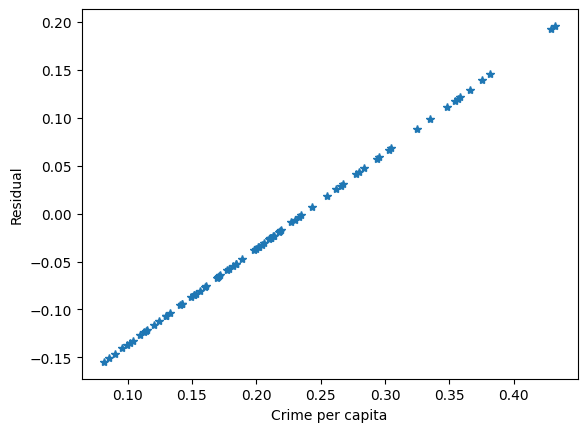

Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0.]
Bias 0.22941777751035114
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0.]
Bias 0.23114489140026787
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.]
Bias 0.22321220370361328
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0.]
Bias 0.229641458463215
Coef [ 0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0.]
Bias 0.2270756945445538


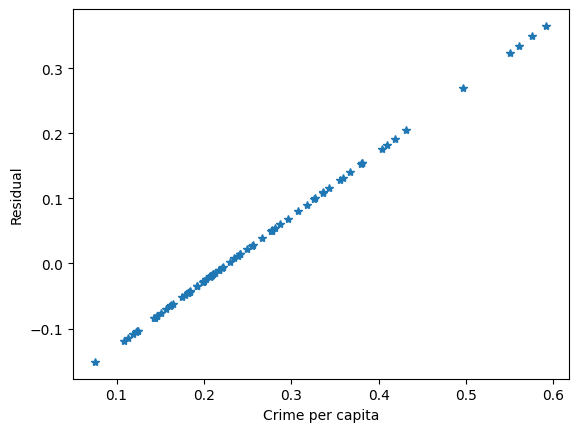

Average MSE train error: 0.012796130388229538
Average MSE validation error: 0.012871057979624402
Average MSE test error: 0.012930047080883805
Average MAE train error: 0.08563024392223065
Average MAE validation error: 0.08581318695360451
Average MAE test error: 0.08604283484169542

Average value in Y: 0.2338318098958433
STD value in Y: 0.1132114802988695




In [64]:
train_pipeline_advanced(
    model_name='LR',
    data=relative_gemeente_features,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

train_pipeline_advanced(
    model_name='Ridge',
    data=relative_gemeente_features,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

train_pipeline_advanced(
    model_name='Lasso',
    data=relative_gemeente_features,
    col_name_to_predict=PREDICT_COL,
    folds=FOLDS,
    seed=SEED,
    column_to_drop=DROP_COL,
    plot_residuals=PLOT_RES
)

Let’s preform some regression analysis to explain our results. Our errors are quite low, but part of this might be explained due to the relative low number that the model is trying to predict; crime per capita is a number between 0 and 1. To make sure our errors are randomly distributed around zero, we plot the residual graphs of each fold.se show us some interesting points. Firstly, the normal regressor without regularization gives us no signs of something weird going on. The residuals look to be uniformly spread around zero. Our plots with regularization do show some weird behaviour as they seem to be showing linearity and thus not being spread uniformly. Ridge seems to be a little less linear than Lasso. Another thing to notice is that Lasso regularization seems to want to set almost all coefficients to zero or near-zero. This should raise alarms bells, as this might mean that the features are not enough to predict the crime number accurately. However, when looking at the correlation between certain features and the crimes per capita statistic, we do see linearity and thus it can almost certainly not be the case that the features cannot predict our total crime. Furthermore, we back this up with the low error that we get and the suspicion that something else is at play arises.
Perhaps the crimes per capita statistics lie al lie very close to each other and therefore the model predicts a straight line might be the best line for a predictor. To make sure this is not the case we plot the crimes per capita in a boxplot. Inspecting this boxplot also does not explain our strange laso result, as the data points do not seem to be centered around one point.

## Guided model from clinic 2

Because we noticed that the errors increased with regularization, we decided to make a plot, where we plot the error against the regularization level. This was heavily inspired by the guided_model_2 code from clinic 2.

In [60]:
#FROM clinic 2 guided model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X = relative_gemeente_features.drop(columns=['crime_per_capita', 'index'])
Y = relative_gemeente_features['crime_per_capita']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=21)


# Specify our model
model = Lasso(copy_X=True)

# Specify CV method and alpha grid
five_fold_cv = KFold(n_splits = 5)
alphas = np.arange(0.1, 1.1, .1)
rmses = np.zeros(len(alphas))

# Grid search over alphas
for i, alpha in enumerate(alphas):
    model.set_params(alpha=alpha)
    model_rmse = 0
    
    # Fit each fold using the other four as training data
    for train_index, test_index in five_fold_cv.split(X_train):
        X_fold_train = X_train.iloc[train_index]
        y_fold_train = y_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_test = y_train.iloc[test_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_predicted = model.predict(X_fold_test)
        model_rmse += MAE(y_fold_test, y_fold_predicted)
    
    # Average RMSE over the five folds for alpha_i
    rmses[i] = model_rmse / 5

optimal_alpha = alphas[rmses == np.min(rmses)]
optimal_alpha = optimal_alpha[0]
model.set_params(alpha=optimal_alpha)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print(f'The validation MSE for this model with '
      f'alpha={float(optimal_alpha)} is {MAE(y_test, y_predicted)}.')

The validation MSE for this model with alpha=0.1 is 0.06090998715194782.


Now, let's see what the plot looks like.

Text(0, 0.5, 'MAE')

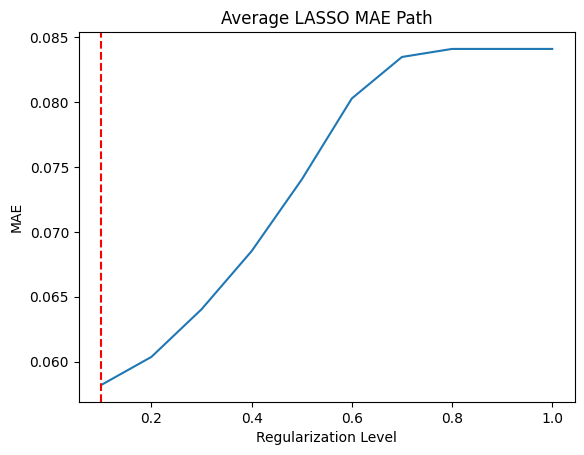

In [61]:
plt.plot(alphas, rmses)
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO MAE Path')
ax.set_xlabel('Regularization Level')
ax.set_ylabel('MAE')

This plot indicates that the regularization is actually increasing the error. That's the reason why the errors went up previously when we added regularization.

## Ethics

All data used was obtained legally and is publicly made available by the Central Bureau of Statistics (CBS) of the Netherlands. The database was created by the CBS based on offences registered and published by local police forces and the Royal Netherlands Marechaussee. When dealing with data from CBS we are awere of the potential bias that government instances might have when it comes to data. However, the Netherlands has a good system of checks and balances in place which when taken into consideration vouches for the trustworthiness of the CBS.

On another note, any predictory model to predict crime rates based on features such as average income, minority populations, unemployment rates and population density rightly raises extreme ethical concerns. A model as the one created can provide very useful insights into socio-economic factors that contribute to crime, but can also reinforce harmful stereotypes and biases toward certain racial groups or class of people. 

One such ethical issue is that of discrimination against minority groups: if a model such as this one suggests that municipalities with a higher percentage of certain racial groups are likely more dangerous areas, it could lead to more extreme policing. This could create a larger barrier between the different racial groups, countering the integration and diverse society that cities strive to be. If individuals from these groups are policed more strongly, or randomly checked on the street by officers, it could exacerbate these existing inequalities.

Furthermore, predictory models are extremely subject to bias and errors. There is no guarantee that the training data used in the model is representative of the entire population, easily leading to possible inaccurate results. If this is the case, policy decisions such as police budgets being divided across municipalities may be flawed, as well as the targeting of certain communities as mentioned in the preceding paragraph.

These ethical concerns will never truly be eliminated, but it is important to ensure that the training data of the regression models is anonymized appropriately, representative and unbiased. These models should also be as transparent as possible (not a black-box), so that the public can see for themselves what factors are driving these decisions.

The Dutch government and police forces would be the main stakeholders in this project. They are also the ones that can benefit from this project by knowing where to allocate policing funds and money towards other measures to tackle crime (such as education or creating safe-spaces). Harmed groups could, as mentioned, include residents of municipalities that are seen as higher risk.